## Step1: Put all libraries and packages at top

### Standard imports

In [1]:
# files and system
import os
import sys

In [2]:
import time
import random

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [3]:
# working with images
import cv2
import imageio
import scipy.ndimage
import skimage.transform

import torchvision.transforms as transforms

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import torchsummary
from tqdm import notebook

### Custom imports

In [5]:
sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

sys.path.insert(0, './notebooks')

In [6]:
sys.path.insert(0, '../models')

# models
from unet import UNet

sys.path.insert(0, '../notebooks')

## Step 2: Fix a seed for reproducibility, and choose the DEVICE

In [7]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda


## Step 3: Set your transforms, e.g, normalisation, resizing, rotation, flip, padding etc

In [9]:
_size = 256, 256
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

## Step 4: Make your train and validation data loader with option to use different preprocessing

In [10]:
path_images = "../data/train-val/images"
path_masks = "../data/train-val/masks"


# pre-defined split
with open('../train-val-split/train.txt', 'r') as f:
    ids_train = [l.strip()+'.jpg' for l in f]
with open('../train-val-split/val.txt', 'r') as f:
    ids_val = [l.strip()+'.jpg' for l in f]


custom_dataset_train = myDataSet(ids_train, path_images, path_masks, transforms=test_transforms)
custom_dataset_val = myDataSet(ids_val, path_images, path_masks, transforms=test_transforms)

print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))
print("My custom validation-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 880 elements
My custom validation-dataset has 120 elements


In [11]:
BATCH_SIZE = 20

# Create dataloaders from datasets with the native pytorch functions
dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

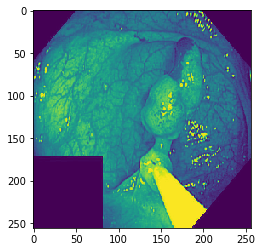

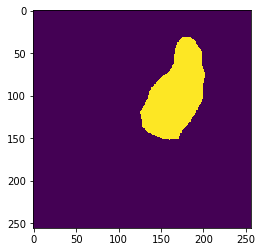

In [12]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)


# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()

In [13]:
custom_dataset_train.__getitem__(image_number)[0].shape

torch.Size([3, 256, 256])

In [14]:
custom_dataset_train.__getitem__(image_number)[1].shape, np.unique(custom_dataset_train.__getitem__(image_number)[1])

(torch.Size([1, 256, 256]), array([0., 1.], dtype=float32))

# Training hyperparameters

In [123]:
# Begin training
model = UNet(channel_in=3, channel_out=1)
model = model.to(DEVICE) # load model to DEVICE

In [124]:
# Define variables for the training
epochs = 100
patience = 10

In [125]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimiser = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

# criterion = IoULoss()
# model_name = 'UNet_IoULoss_baseline'

# criterion = nn.BCEWithLogitsLoss()
# model_name = 'UNet_BCELoss_baseline'

criterion = IoUBCELoss()
model_name = 'UNet_IoUBCELoss_baseline'


# Training

 Epoch: 0 of 100, Iter.: 44 of 44, Train Loss: 0.425215, IoU: 0.293079
 Epoch: 0 of 100, Iter.: 44 of 44, Valid Loss: 0.386984, IoU: 0.252349


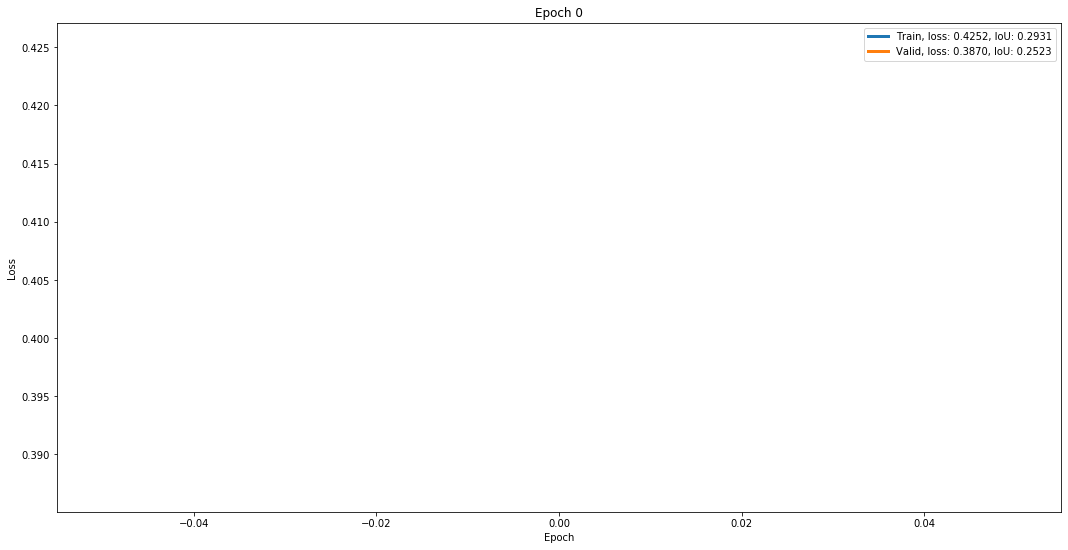

 Epoch: 1 of 100, Iter.: 44 of 44, Train Loss: 0.258906, IoU: 0.381107
 Epoch: 1 of 100, Iter.: 44 of 44, Valid Loss: 0.278633, IoU: 0.326643


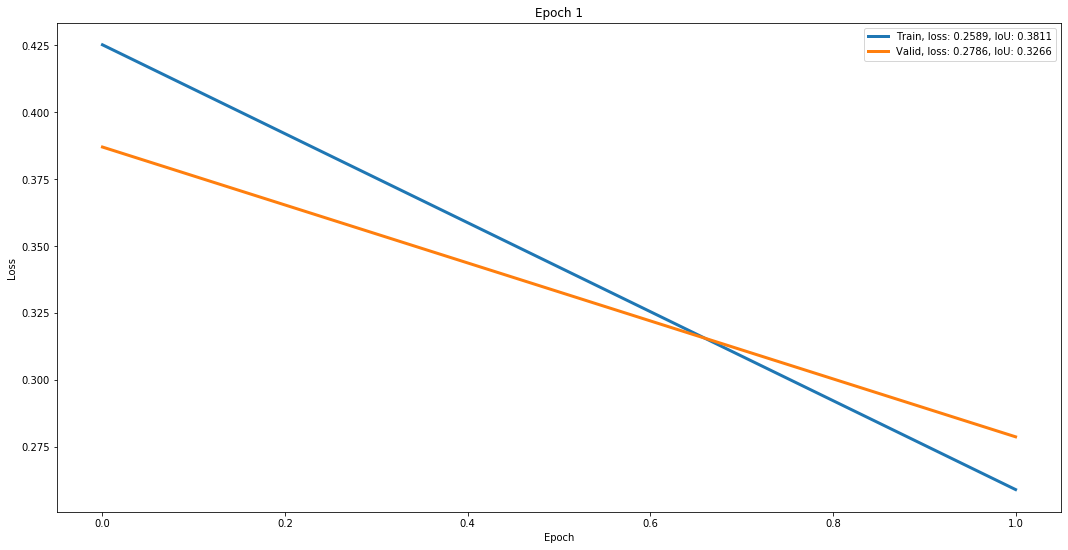

 Epoch: 2 of 100, Iter.: 44 of 44, Train Loss: 0.178531, IoU: 0.433936
 Epoch: 2 of 100, Iter.: 44 of 44, Valid Loss: 0.195575, IoU: 0.374416


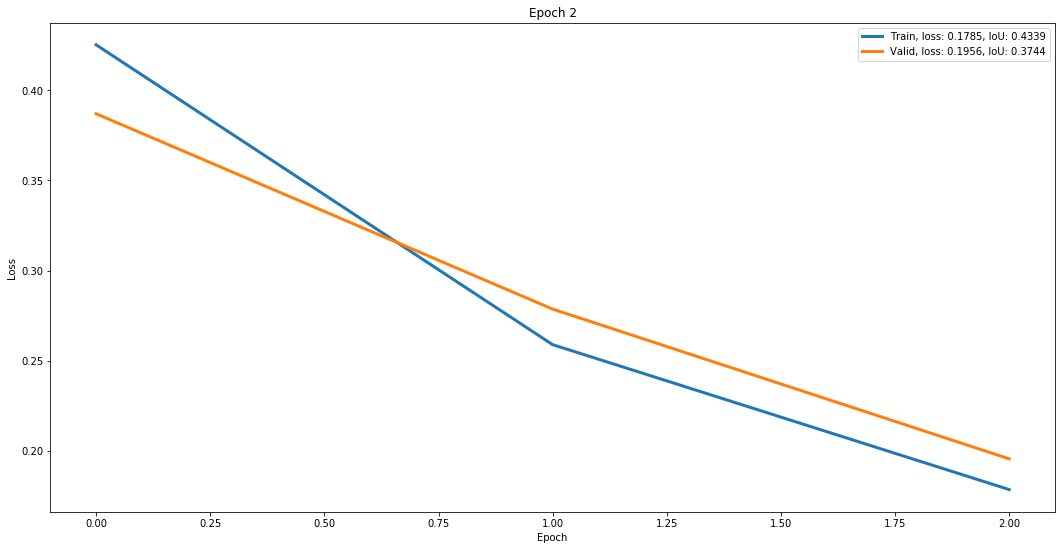

 Epoch: 3 of 100, Iter.: 44 of 44, Train Loss: 0.127467, IoU: 0.452118
 Epoch: 3 of 100, Iter.: 44 of 44, Valid Loss: 0.151375, IoU: 0.382111


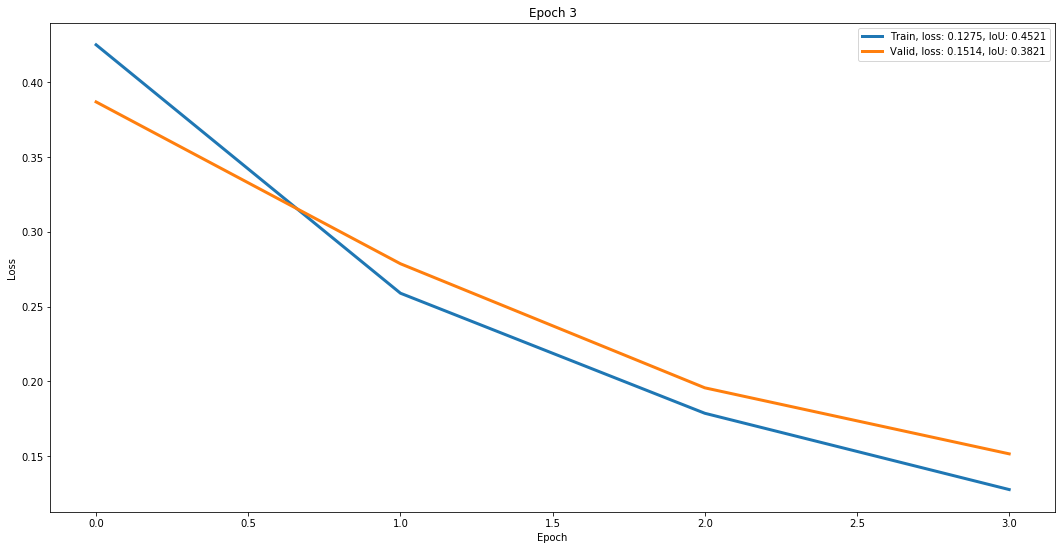

 Epoch: 4 of 100, Iter.: 44 of 44, Train Loss: 0.078390, IoU: 0.471775
 Epoch: 4 of 100, Iter.: 44 of 44, Valid Loss: 0.267017, IoU: 0.350064


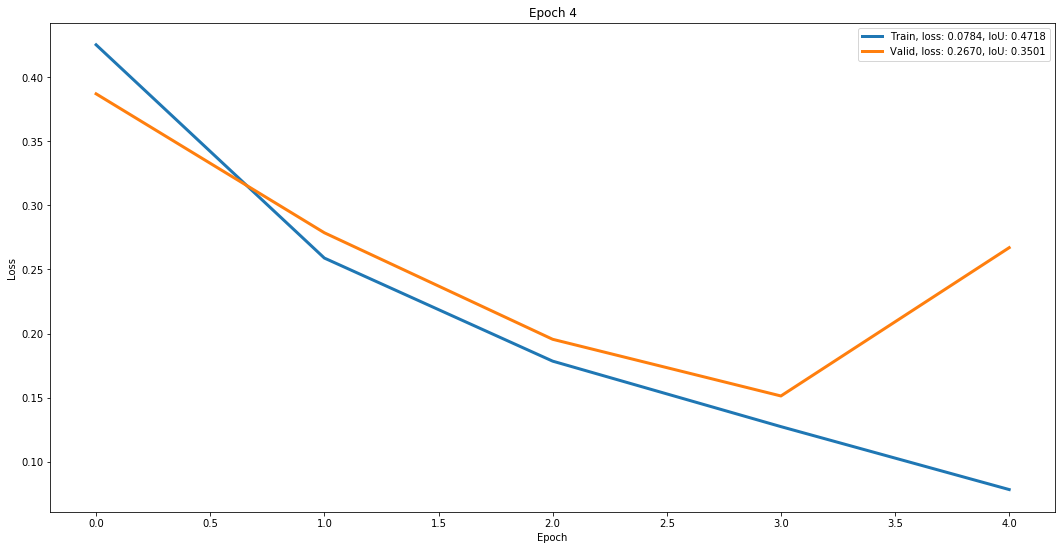

 Epoch: 5 of 100, Iter.: 44 of 44, Train Loss: 0.038599, IoU: 0.498004
 Epoch: 5 of 100, Iter.: 44 of 44, Valid Loss: 0.209944, IoU: 0.360741


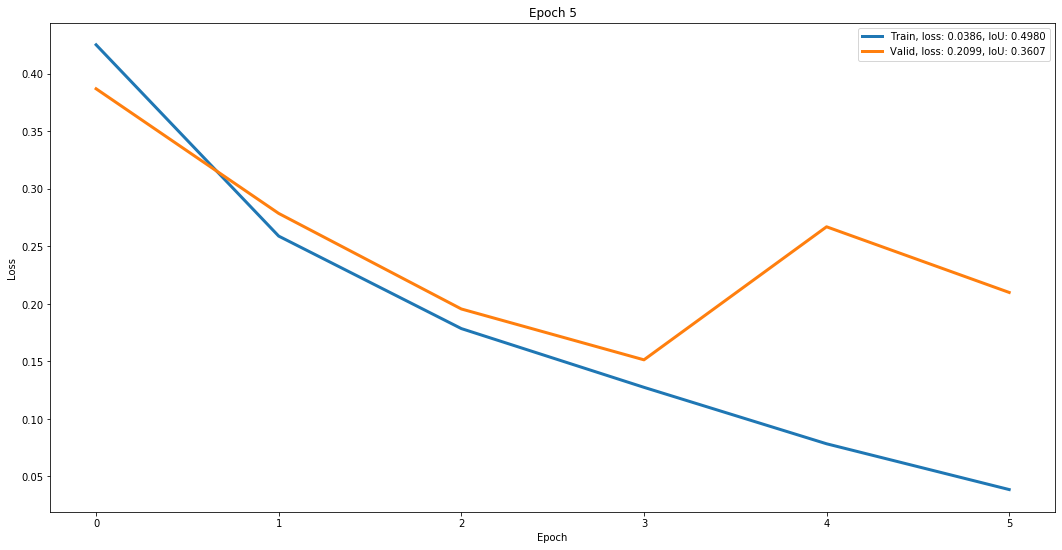

 Epoch: 6 of 100, Iter.: 44 of 44, Train Loss: -0.002842, IoU: 0.527270
 Epoch: 6 of 100, Iter.: 44 of 44, Valid Loss: 0.126662, IoU: 0.434002


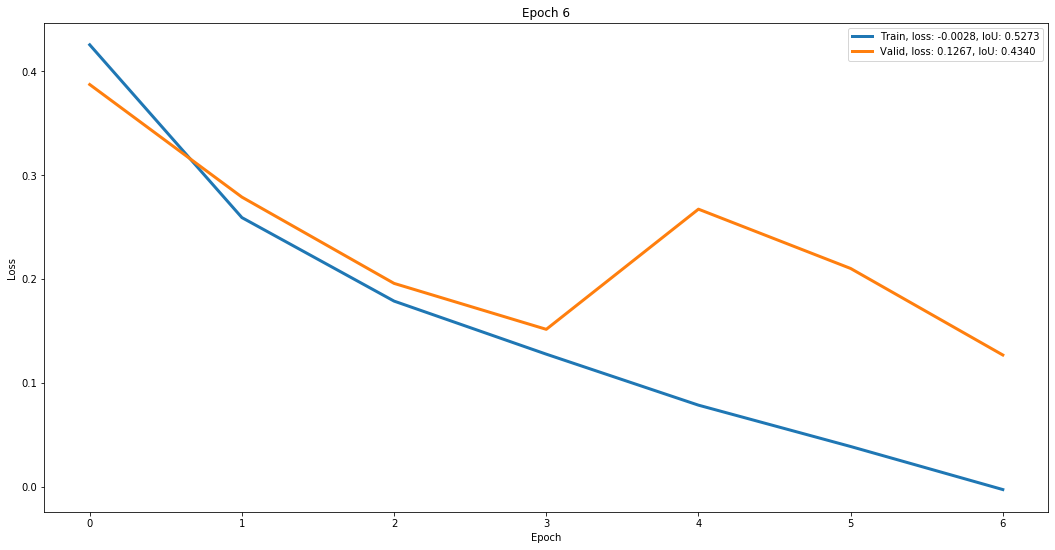

 Epoch: 7 of 100, Iter.: 44 of 44, Train Loss: -0.052615, IoU: 0.559602
 Epoch: 7 of 100, Iter.: 44 of 44, Valid Loss: 0.101617, IoU: 0.436771


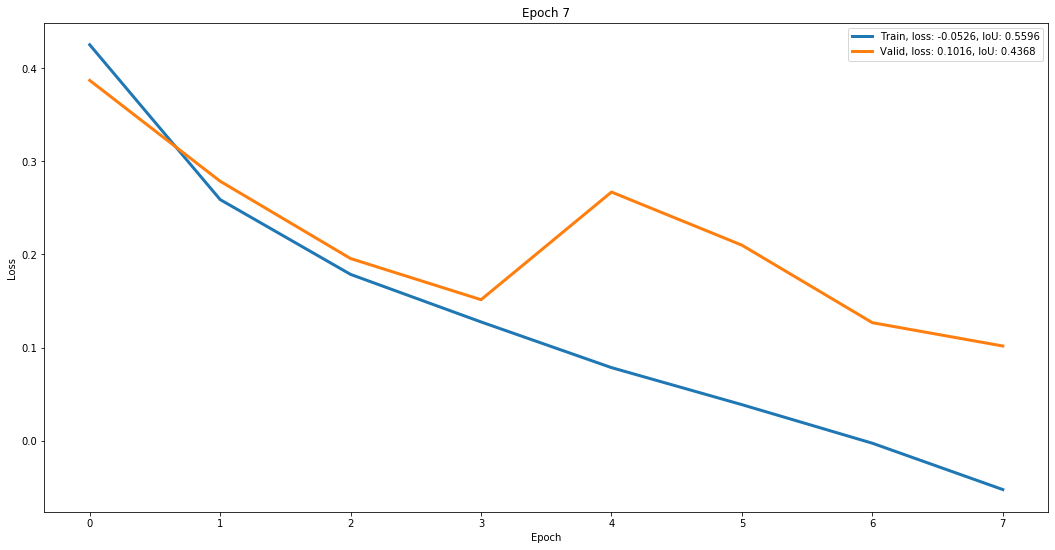

 Epoch: 8 of 100, Iter.: 44 of 44, Train Loss: -0.102274, IoU: 0.599699
 Epoch: 8 of 100, Iter.: 44 of 44, Valid Loss: 0.096610, IoU: 0.439284


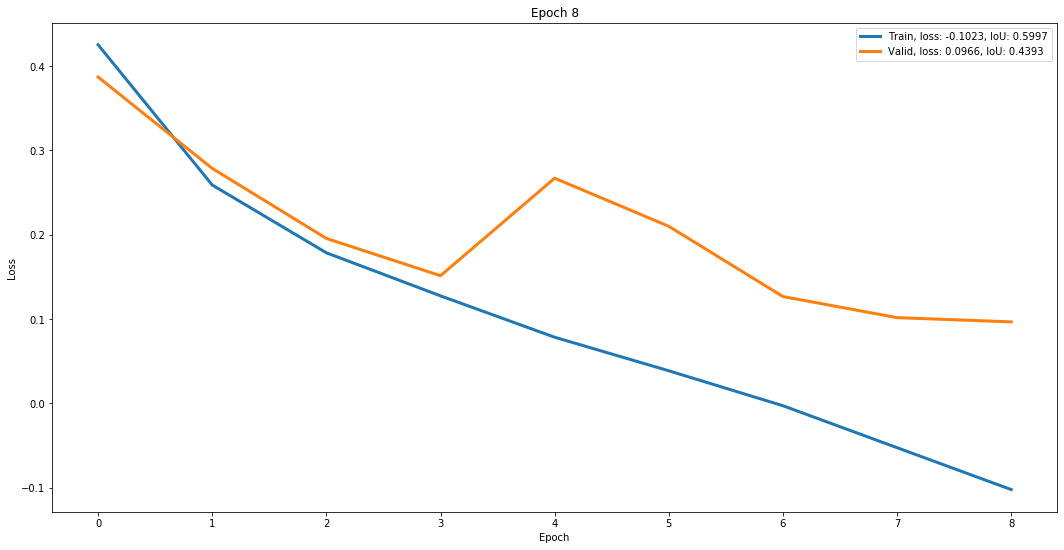

 Epoch: 9 of 100, Iter.: 44 of 44, Train Loss: -0.145055, IoU: 0.6280617
 Epoch: 9 of 100, Iter.: 44 of 44, Valid Loss: 0.036366, IoU: 0.477388


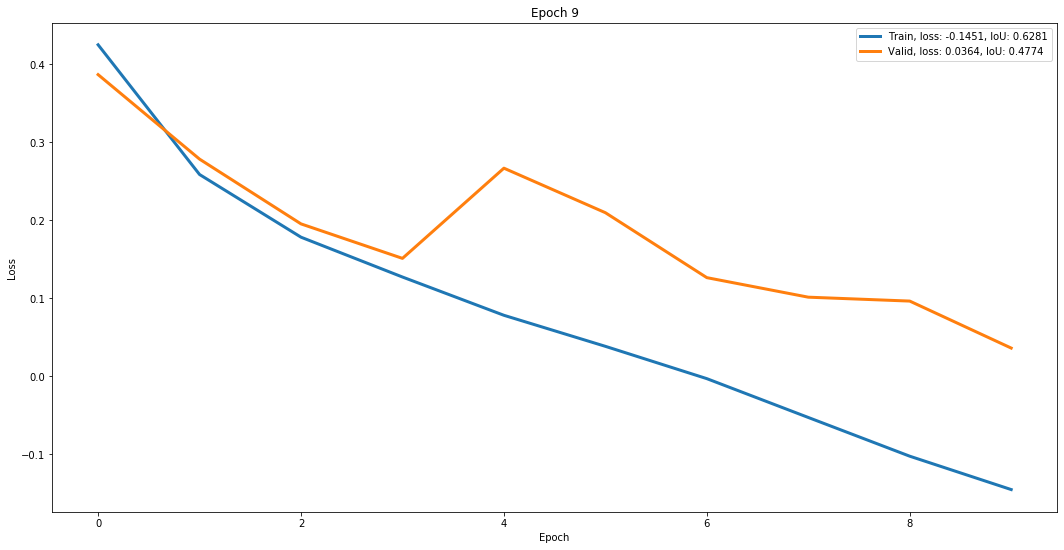

 Epoch: 10 of 100, Iter.: 44 of 44, Train Loss: -0.174711, IoU: 0.6396530
 Epoch: 10 of 100, Iter.: 44 of 44, Valid Loss: 0.015008, IoU: 0.474175


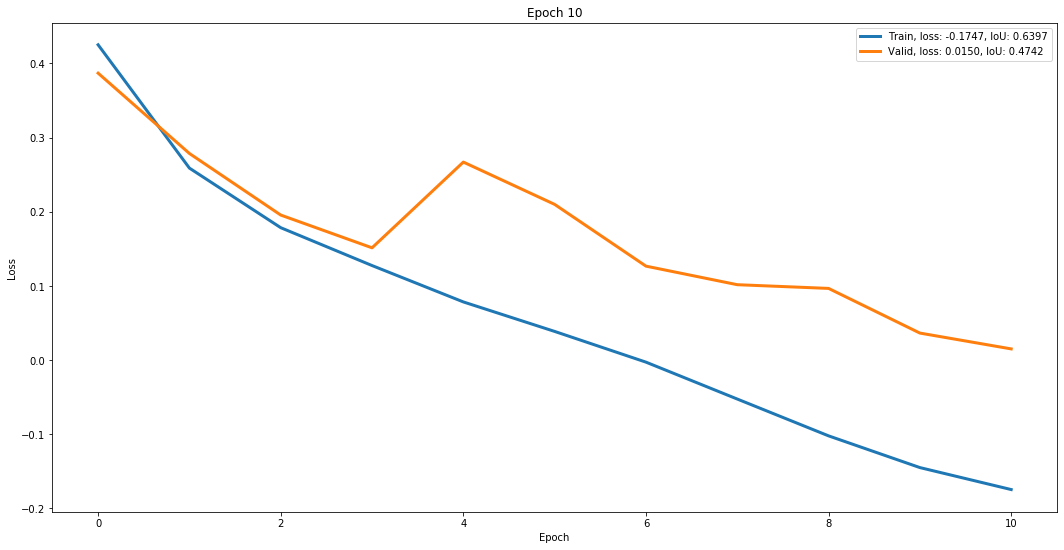

 Epoch: 11 of 100, Iter.: 44 of 44, Train Loss: -0.208422, IoU: 0.6612077
 Epoch: 11 of 100, Iter.: 44 of 44, Valid Loss: -0.007177, IoU: 0.488709


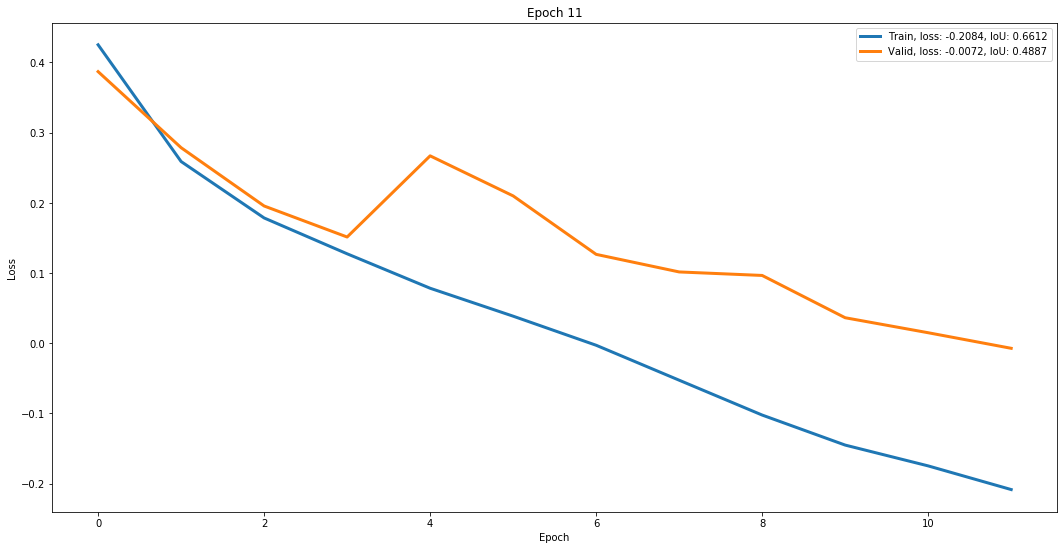

 Epoch: 12 of 100, Iter.: 44 of 44, Train Loss: -0.241947, IoU: 0.6781938
 Epoch: 12 of 100, Iter.: 44 of 44, Valid Loss: -0.015768, IoU: 0.494400


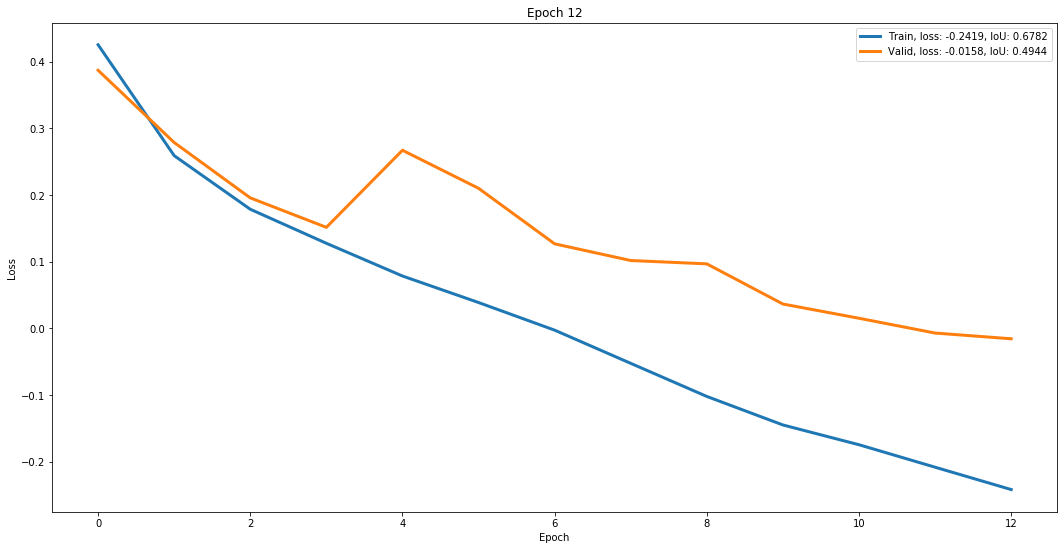

 Epoch: 13 of 100, Iter.: 44 of 44, Train Loss: -0.279319, IoU: 0.6942316
 Epoch: 13 of 100, Iter.: 44 of 44, Valid Loss: -0.002016, IoU: 0.491994


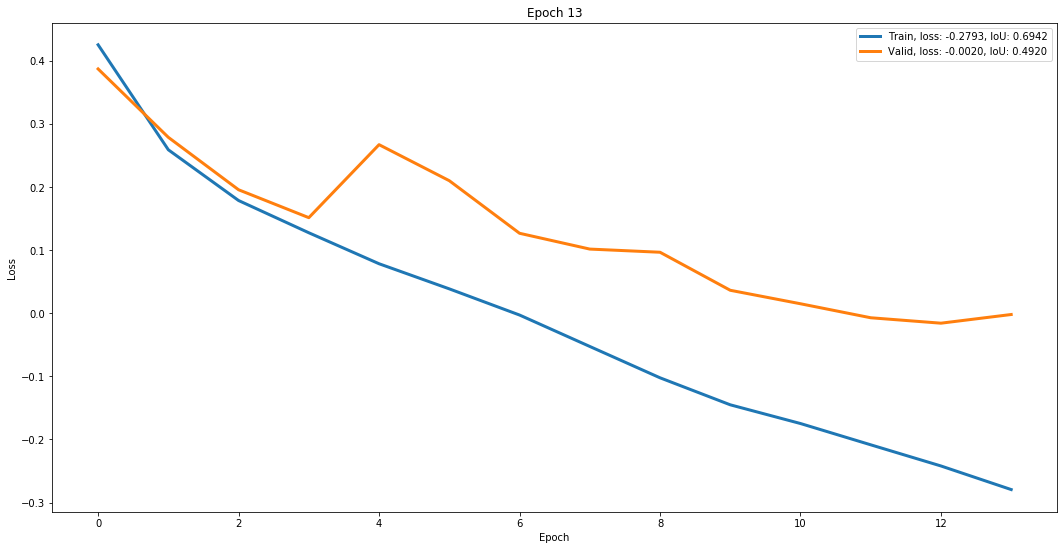

 Epoch: 14 of 100, Iter.: 44 of 44, Train Loss: -0.330301, IoU: 0.7247926
 Epoch: 14 of 100, Iter.: 44 of 44, Valid Loss: 0.056989, IoU: 0.479062


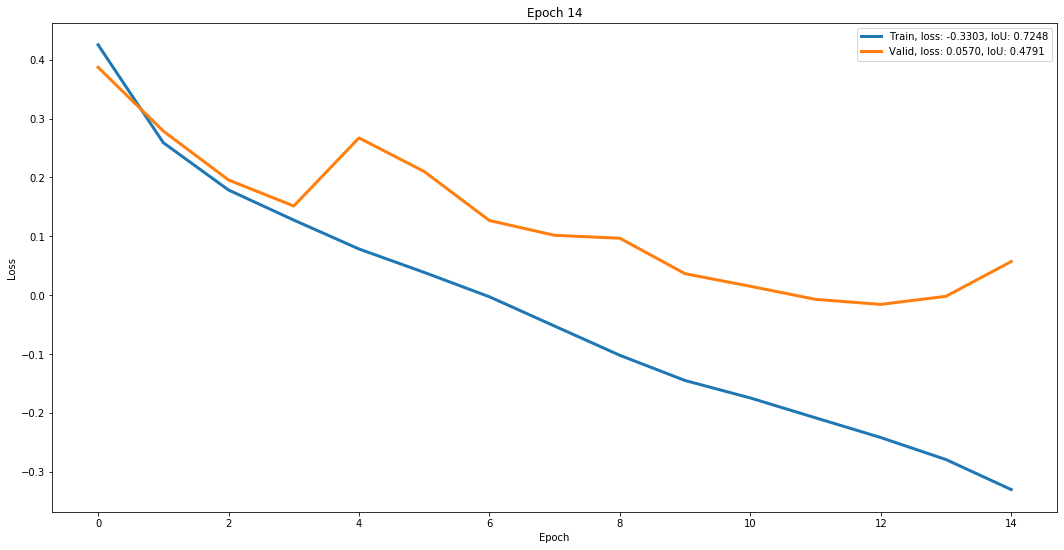

 Epoch: 15 of 100, Iter.: 44 of 44, Train Loss: -0.366830, IoU: 0.7434718
 Epoch: 15 of 100, Iter.: 44 of 44, Valid Loss: -0.116158, IoU: 0.561992


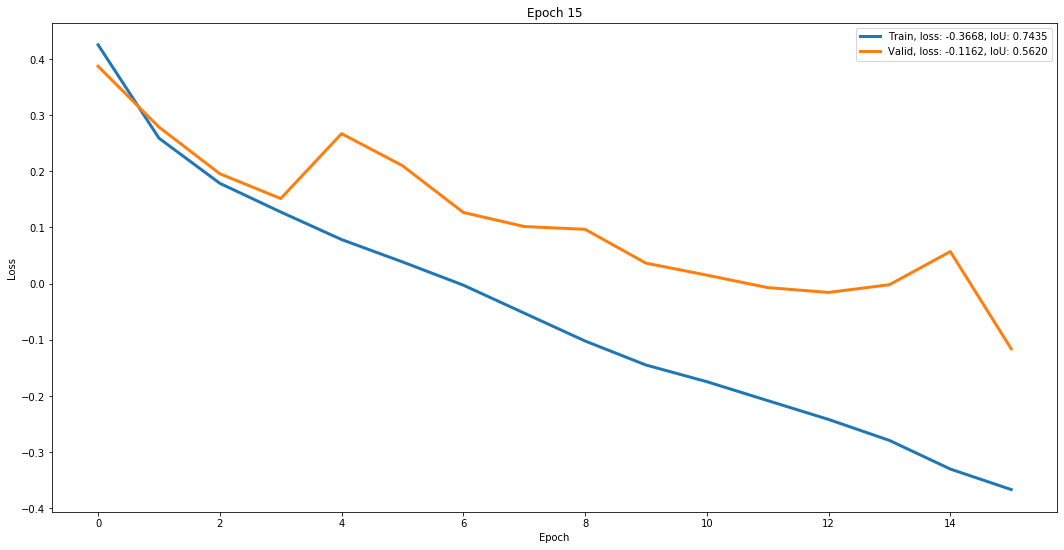

 Epoch: 16 of 100, Iter.: 44 of 44, Train Loss: -0.390940, IoU: 0.7487416
 Epoch: 16 of 100, Iter.: 44 of 44, Valid Loss: -0.030896, IoU: 0.511319


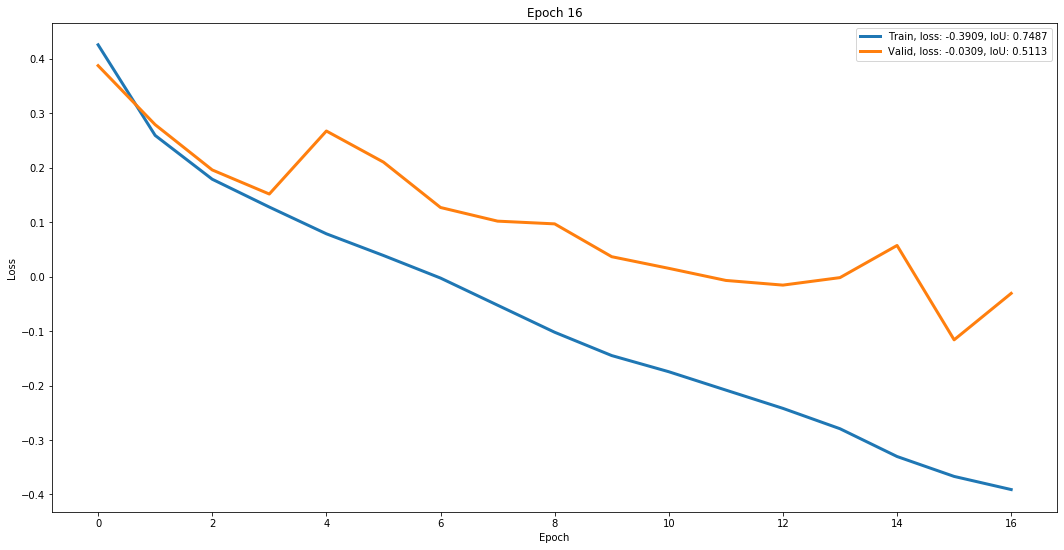

 Epoch: 17 of 100, Iter.: 44 of 44, Train Loss: -0.428121, IoU: 0.7668273
 Epoch: 17 of 100, Iter.: 44 of 44, Valid Loss: -0.041283, IoU: 0.492578


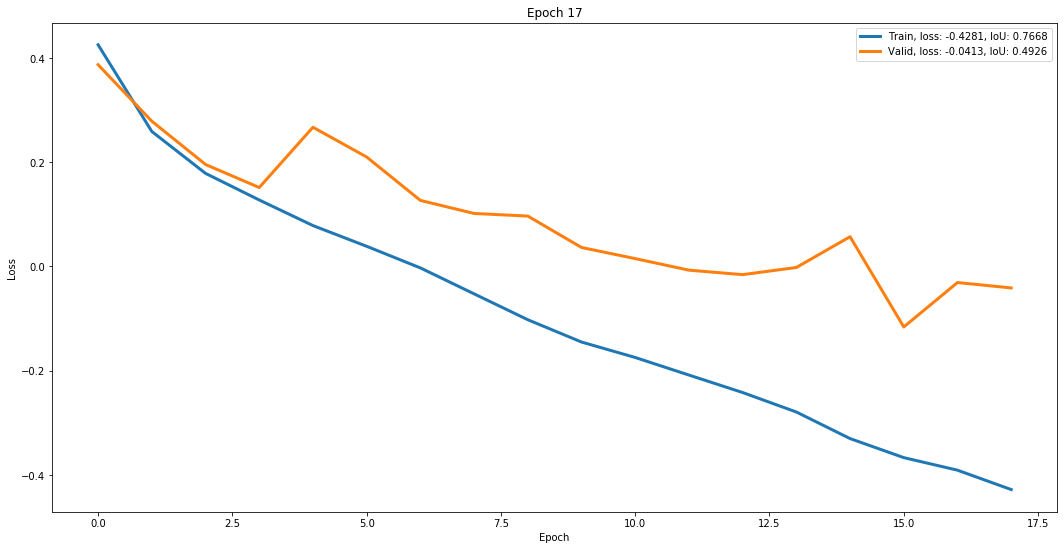

 Epoch: 18 of 100, Iter.: 44 of 44, Train Loss: -0.462829, IoU: 0.7776177
 Epoch: 18 of 100, Iter.: 44 of 44, Valid Loss: -0.152147, IoU: 0.571077


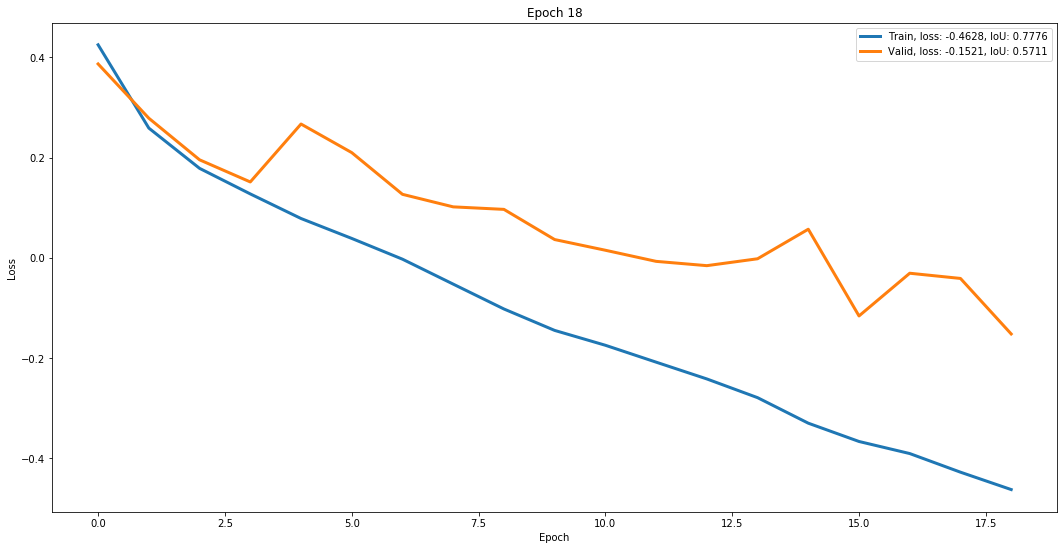

 Epoch: 19 of 100, Iter.: 44 of 44, Train Loss: -0.488461, IoU: 0.7883070
 Epoch: 19 of 100, Iter.: 44 of 44, Valid Loss: -0.095190, IoU: 0.532951


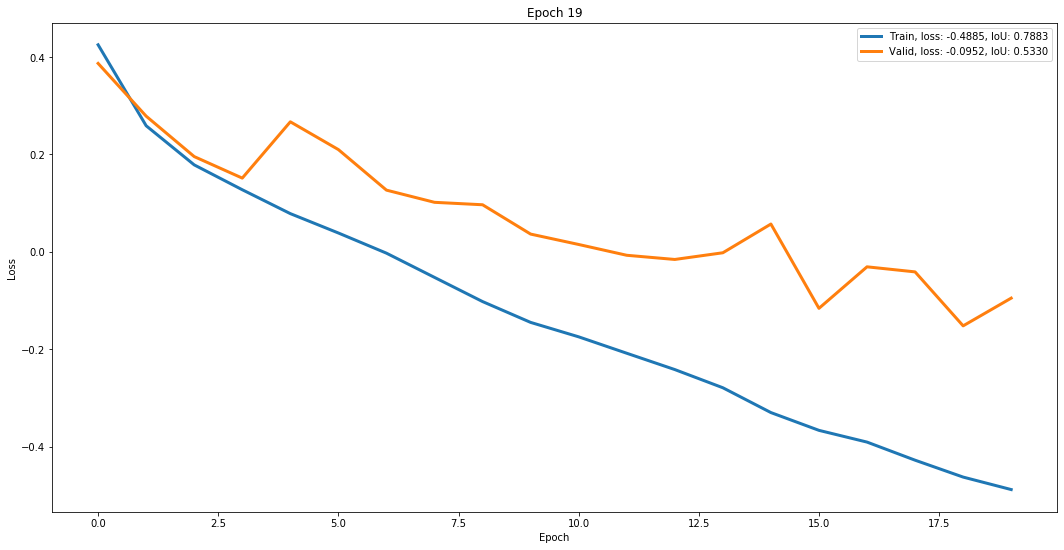

 Epoch: 20 of 100, Iter.: 44 of 44, Train Loss: -0.513150, IoU: 0.7977270
 Epoch: 20 of 100, Iter.: 44 of 44, Valid Loss: -0.076790, IoU: 0.516551


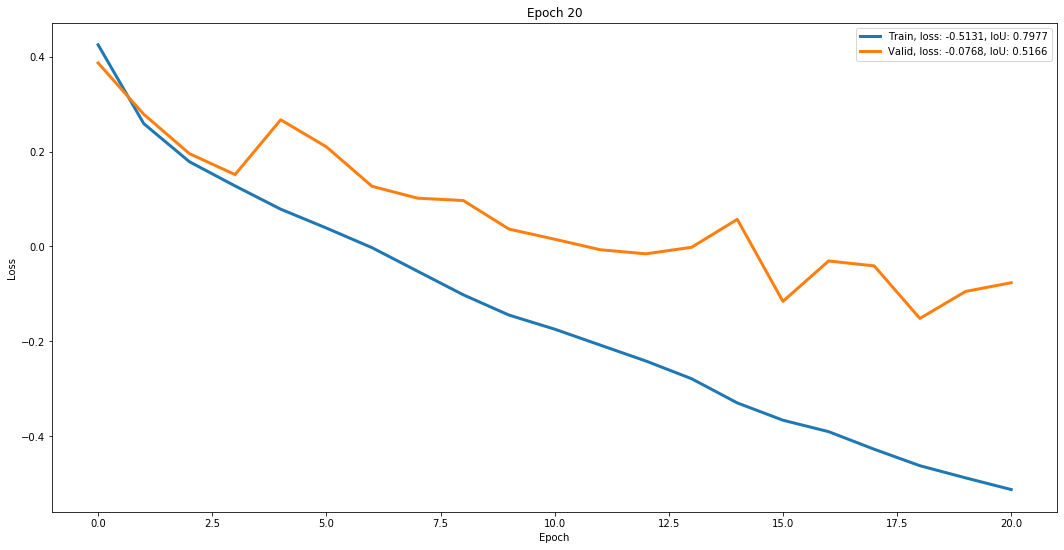

 Epoch: 21 of 100, Iter.: 44 of 44, Train Loss: -0.531394, IoU: 0.7989682
 Epoch: 21 of 100, Iter.: 44 of 44, Valid Loss: -0.175502, IoU: 0.579121


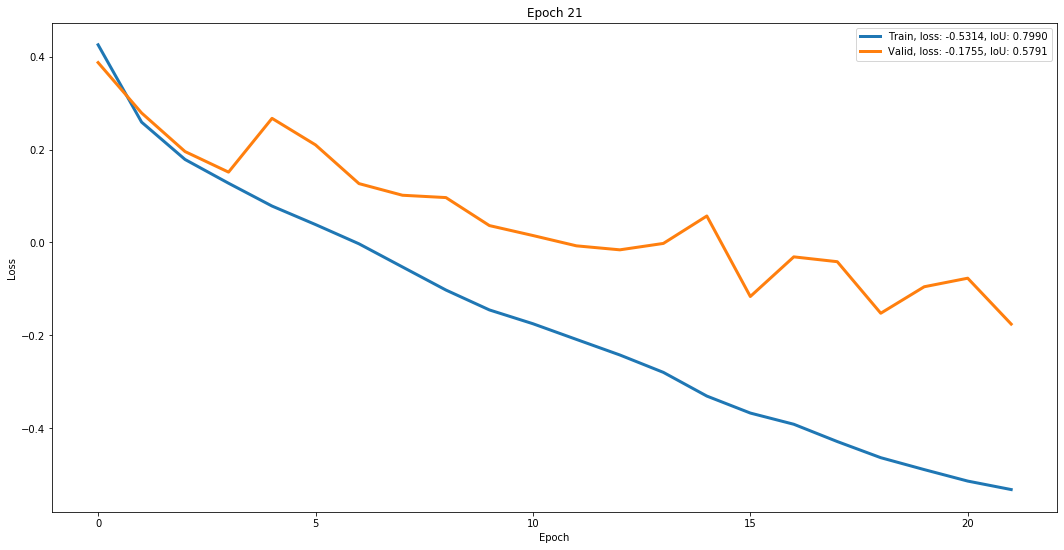

 Epoch: 22 of 100, Iter.: 44 of 44, Train Loss: -0.560156, IoU: 0.8118476
 Epoch: 22 of 100, Iter.: 44 of 44, Valid Loss: -0.195046, IoU: 0.581221


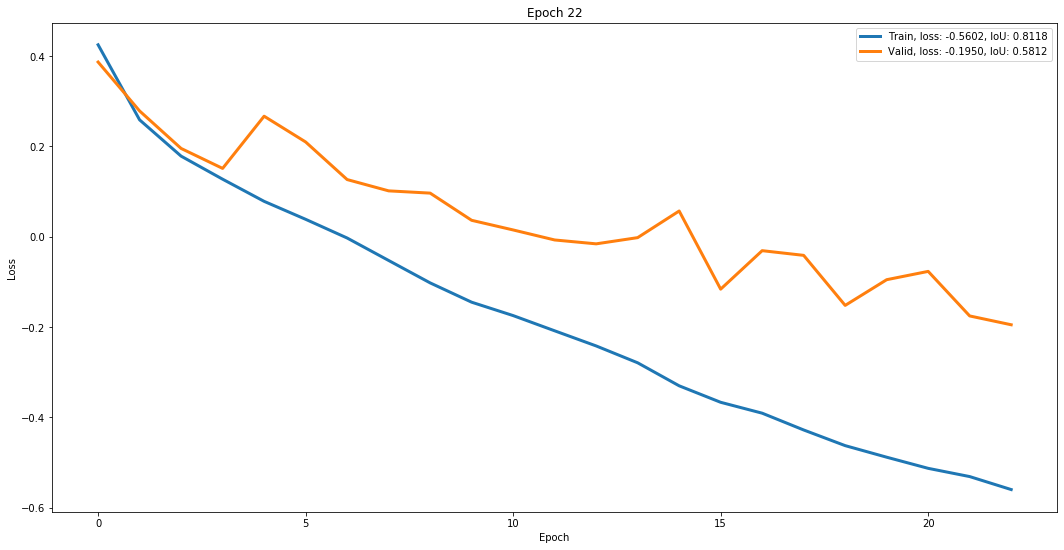

 Epoch: 23 of 100, Iter.: 44 of 44, Train Loss: -0.591378, IoU: 0.8273780
 Epoch: 23 of 100, Iter.: 44 of 44, Valid Loss: -0.098520, IoU: 0.536063


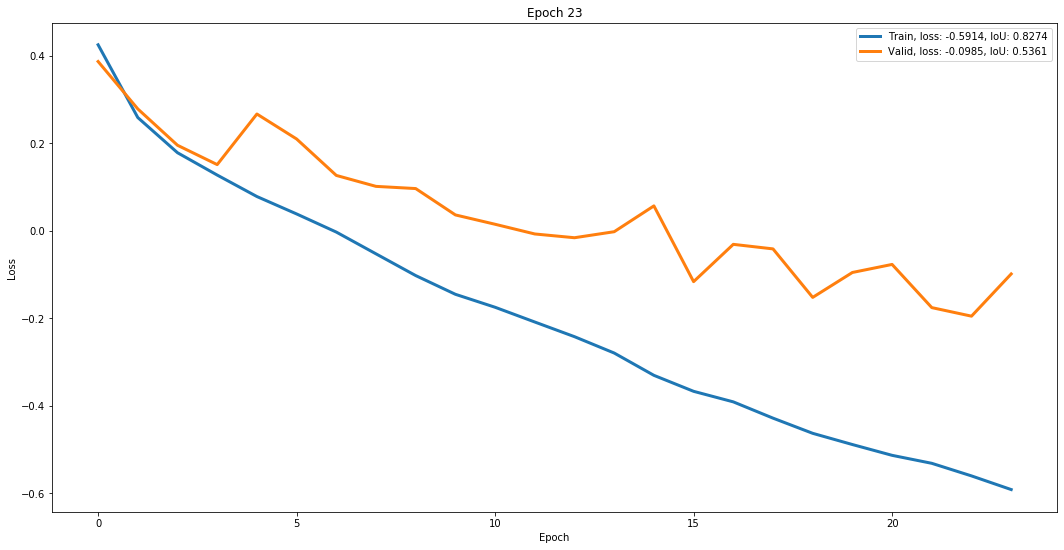

 Epoch: 24 of 100, Iter.: 44 of 44, Train Loss: -0.622138, IoU: 0.8397646
 Epoch: 24 of 100, Iter.: 44 of 44, Valid Loss: -0.251716, IoU: 0.618116


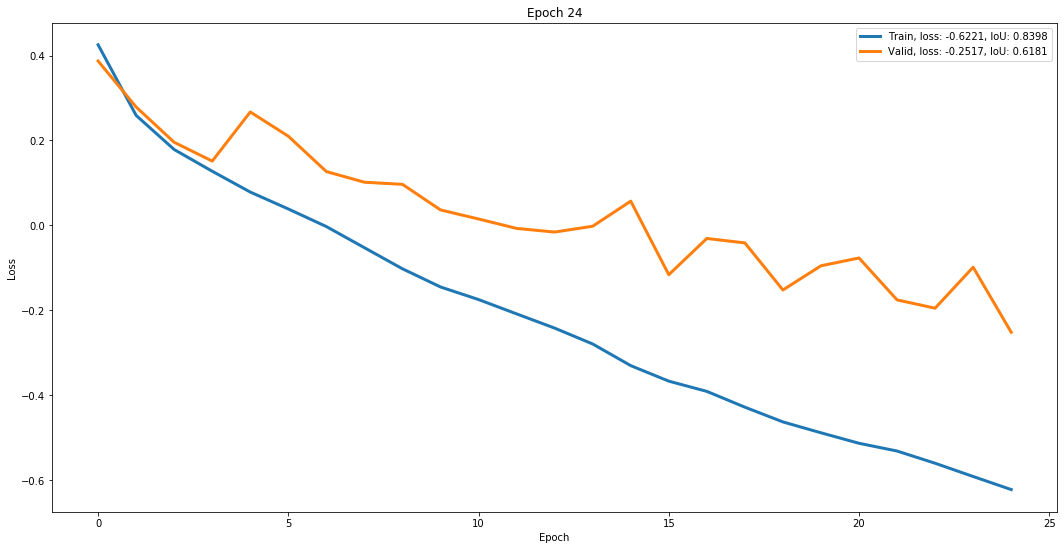

 Epoch: 25 of 100, Iter.: 44 of 44, Train Loss: -0.641994, IoU: 0.8447367
 Epoch: 25 of 100, Iter.: 44 of 44, Valid Loss: -0.151387, IoU: 0.568432


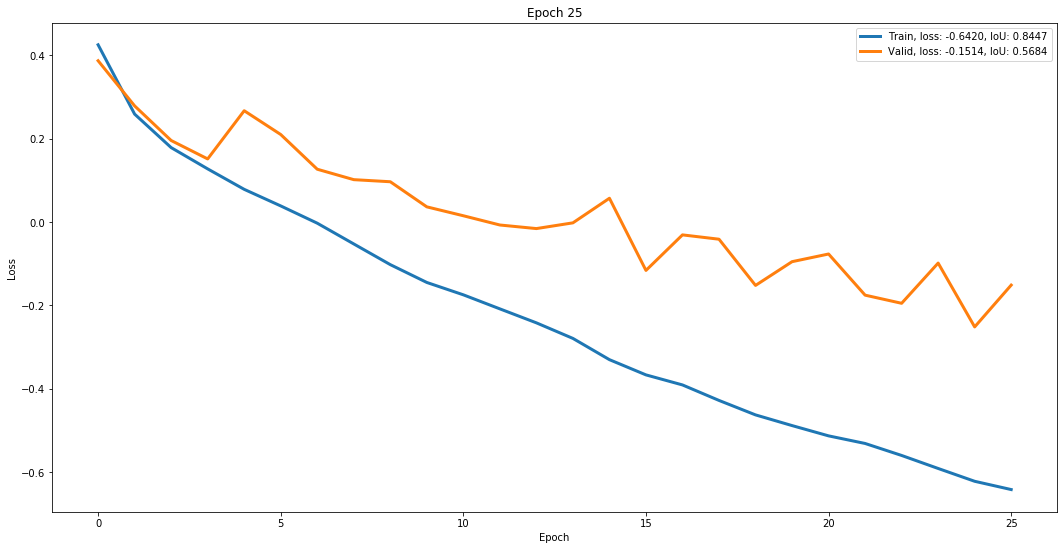

 Epoch: 26 of 100, Iter.: 44 of 44, Train Loss: -0.663688, IoU: 0.8563641
 Epoch: 26 of 100, Iter.: 44 of 44, Valid Loss: -0.191511, IoU: 0.598728


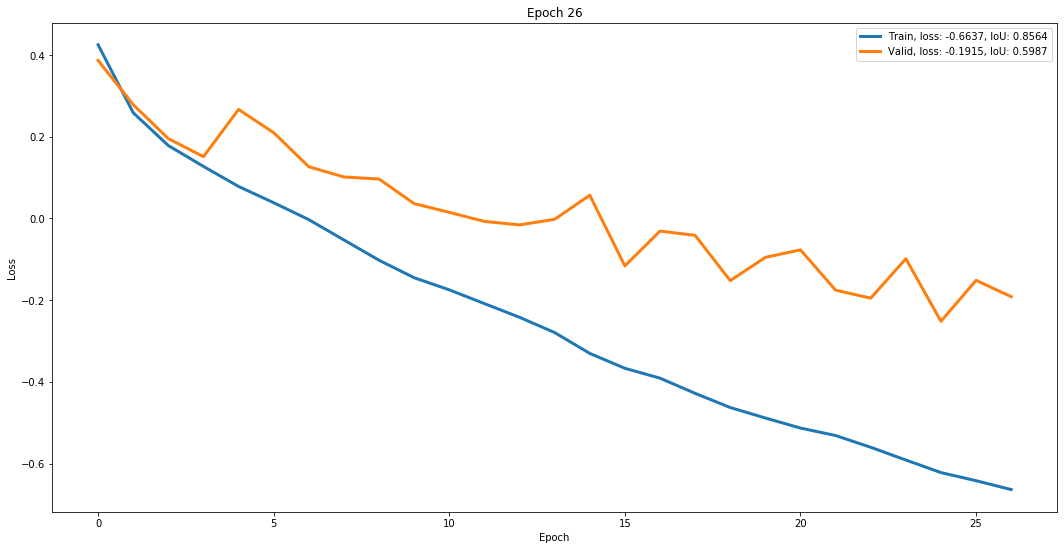

 Epoch: 27 of 100, Iter.: 44 of 44, Train Loss: -0.681386, IoU: 0.8583248
 Epoch: 27 of 100, Iter.: 44 of 44, Valid Loss: -0.175408, IoU: 0.586278


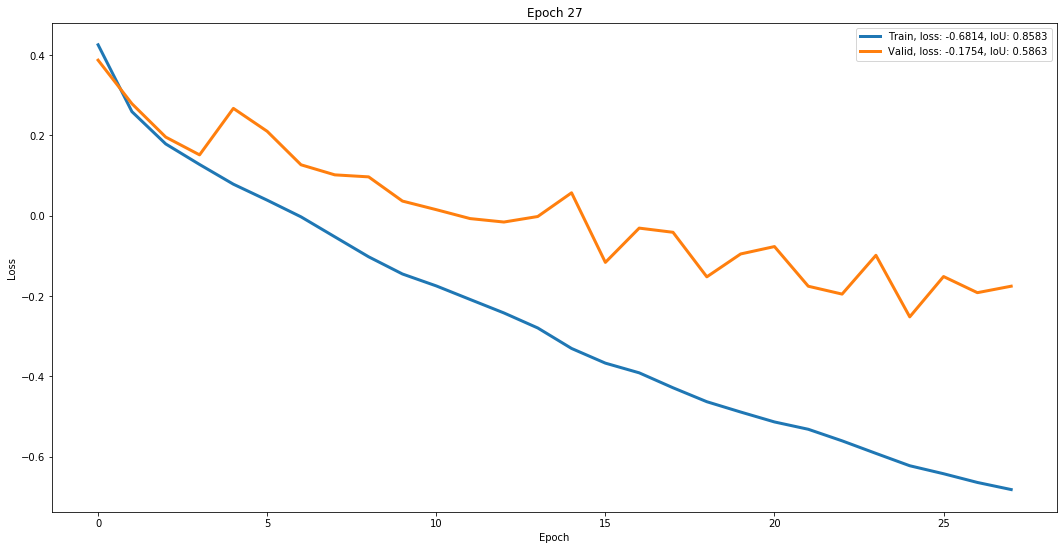

 Epoch: 28 of 100, Iter.: 44 of 44, Train Loss: -0.700692, IoU: 0.8662008
 Epoch: 28 of 100, Iter.: 44 of 44, Valid Loss: -0.187598, IoU: 0.586963


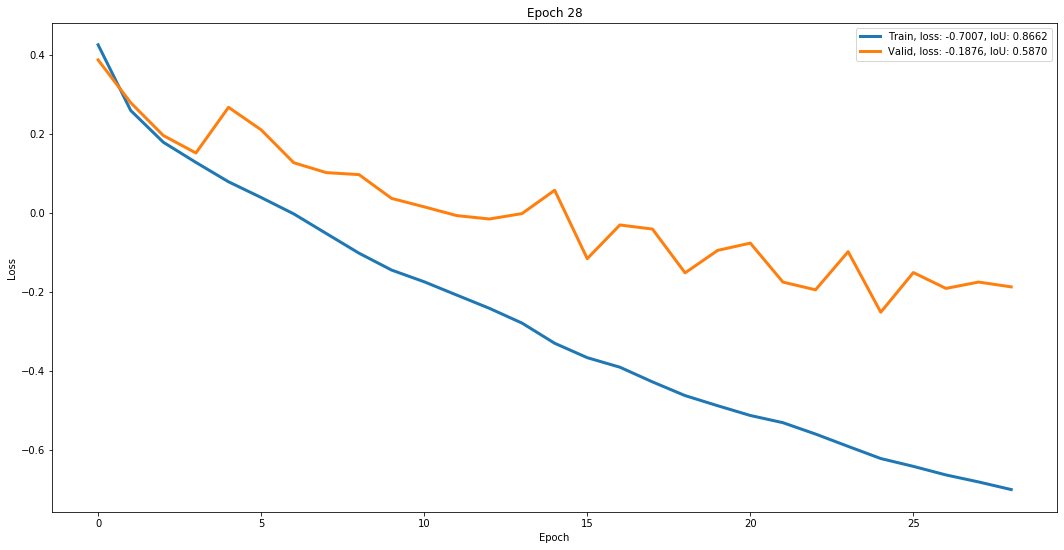

 Epoch: 29 of 100, Iter.: 44 of 44, Train Loss: -0.714294, IoU: 0.8678457
 Epoch: 29 of 100, Iter.: 44 of 44, Valid Loss: -0.251007, IoU: 0.613399


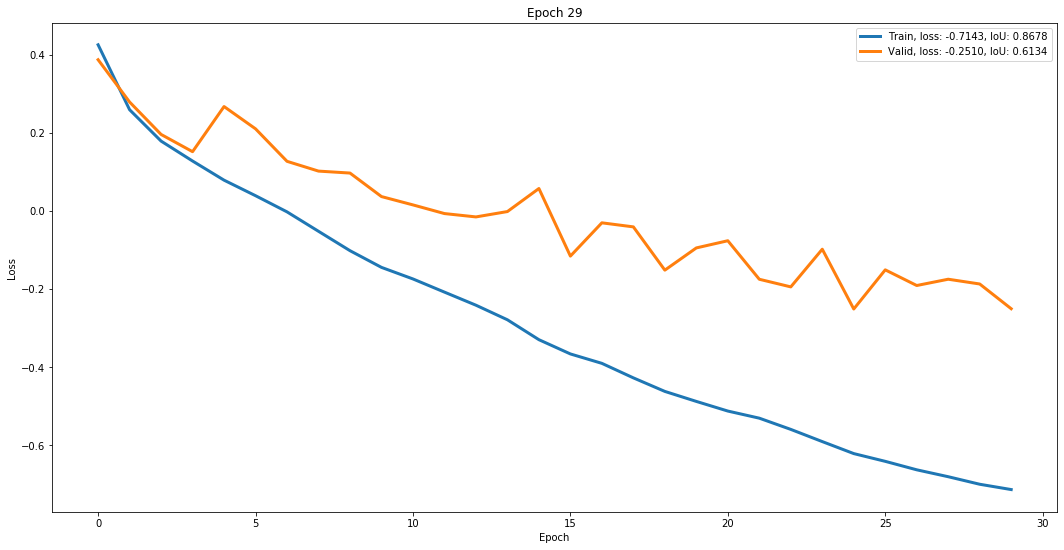

 Epoch: 30 of 100, Iter.: 44 of 44, Train Loss: -0.731052, IoU: 0.8753853
 Epoch: 30 of 100, Iter.: 44 of 44, Valid Loss: -0.222663, IoU: 0.599551


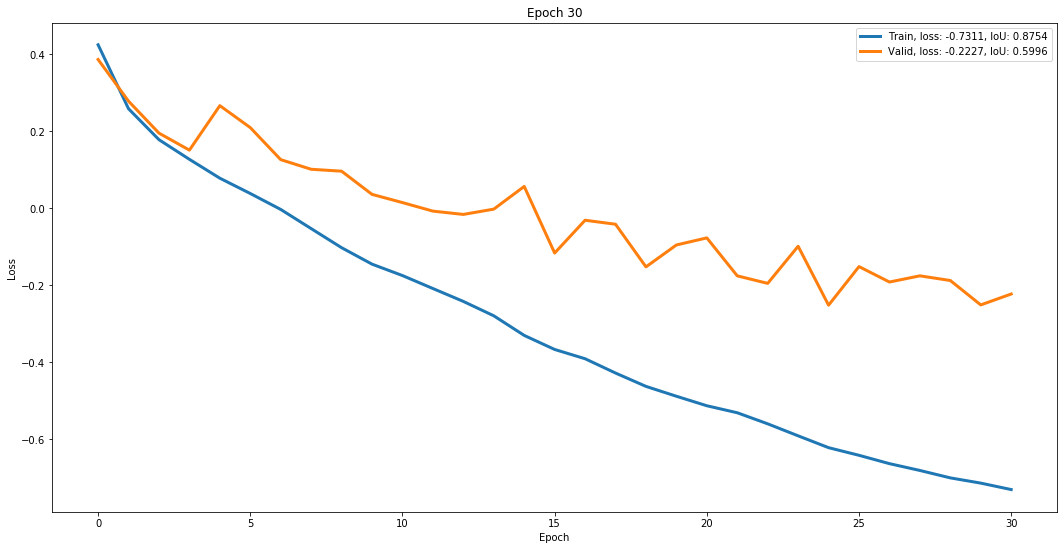

 Epoch: 31 of 100, Iter.: 44 of 44, Train Loss: -0.732219, IoU: 0.8693520
 Epoch: 31 of 100, Iter.: 44 of 44, Valid Loss: -0.126280, IoU: 0.571487


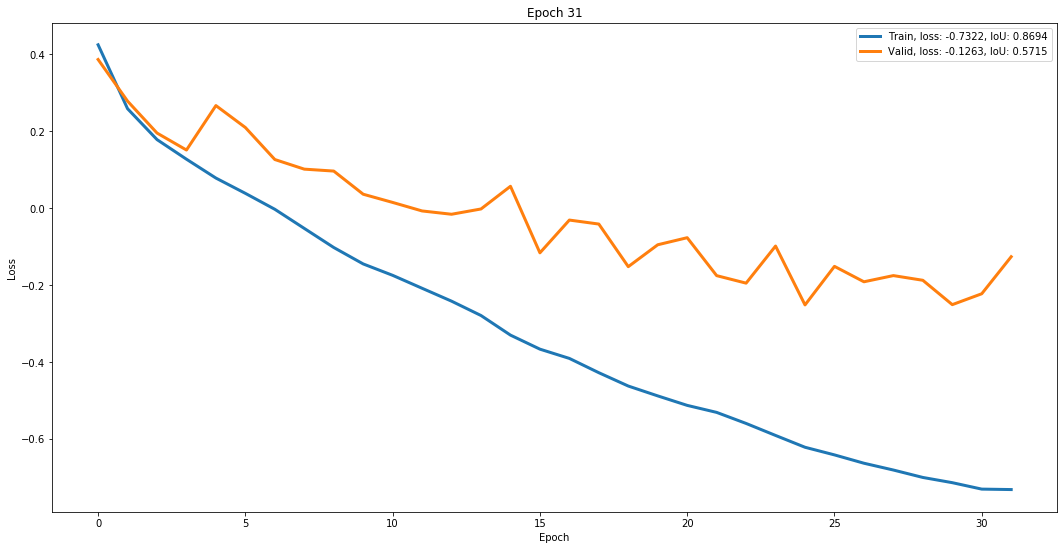

 Epoch: 32 of 100, Iter.: 44 of 44, Train Loss: -0.754212, IoU: 0.8825483
 Epoch: 32 of 100, Iter.: 44 of 44, Valid Loss: -0.234553, IoU: 0.616616


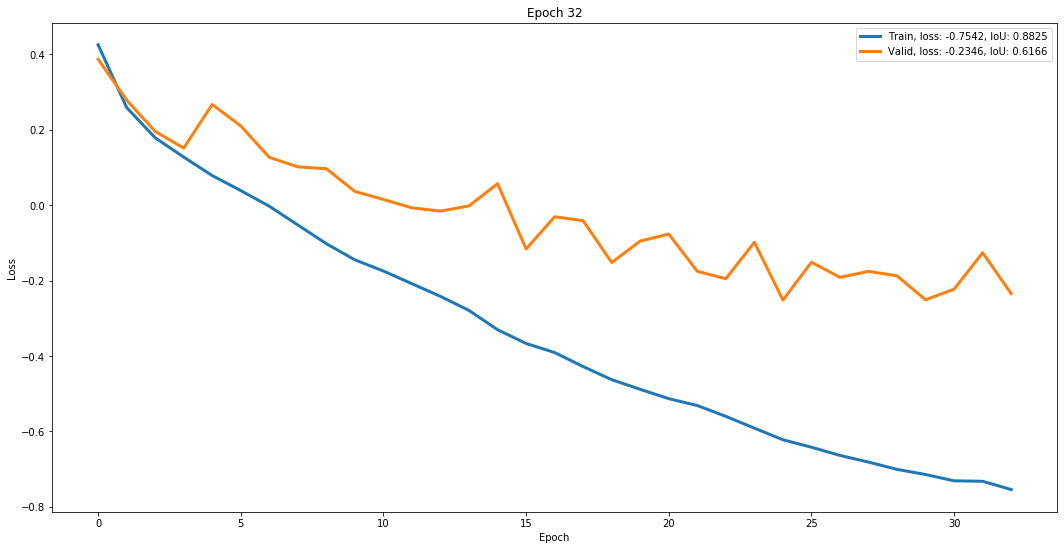

 Epoch: 33 of 100, Iter.: 44 of 44, Train Loss: -0.764180, IoU: 0.8846382
 Epoch: 33 of 100, Iter.: 44 of 44, Valid Loss: -0.262832, IoU: 0.618687


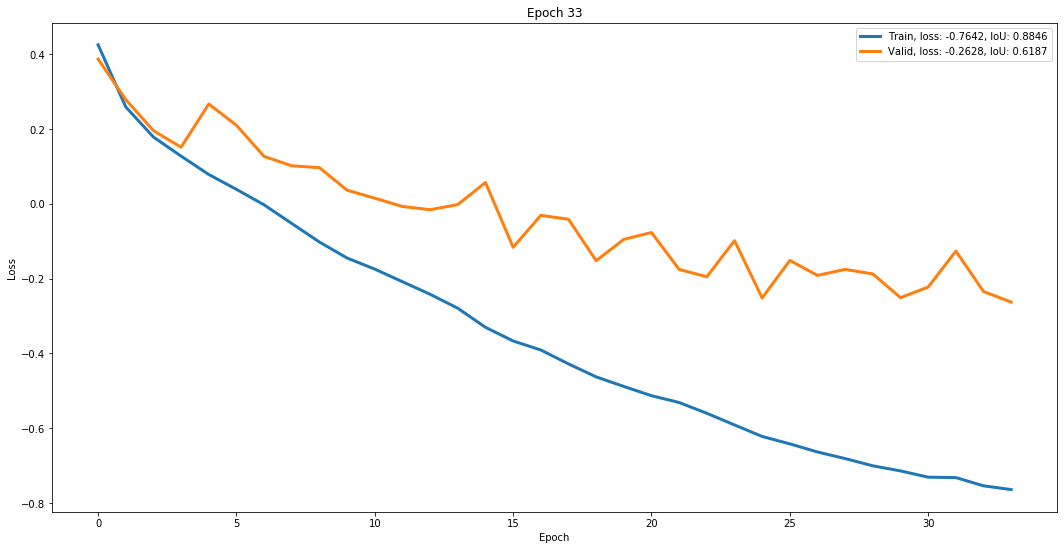

 Epoch: 34 of 100, Iter.: 44 of 44, Train Loss: -0.783822, IoU: 0.8940486
 Epoch: 34 of 100, Iter.: 44 of 44, Valid Loss: -0.261126, IoU: 0.625354


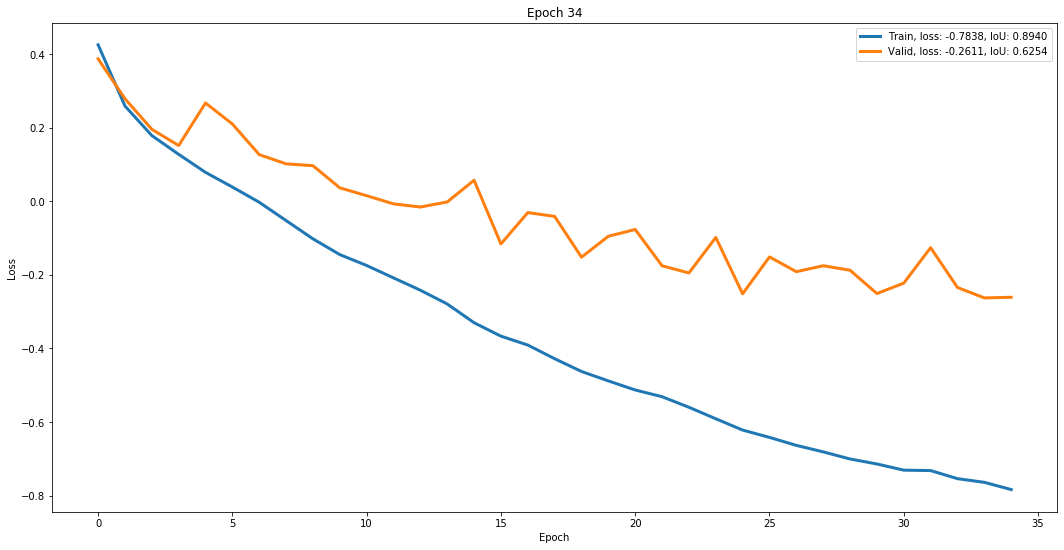

 Epoch: 35 of 100, Iter.: 44 of 44, Train Loss: -0.797639, IoU: 0.9003256
 Epoch: 35 of 100, Iter.: 44 of 44, Valid Loss: -0.248486, IoU: 0.624280


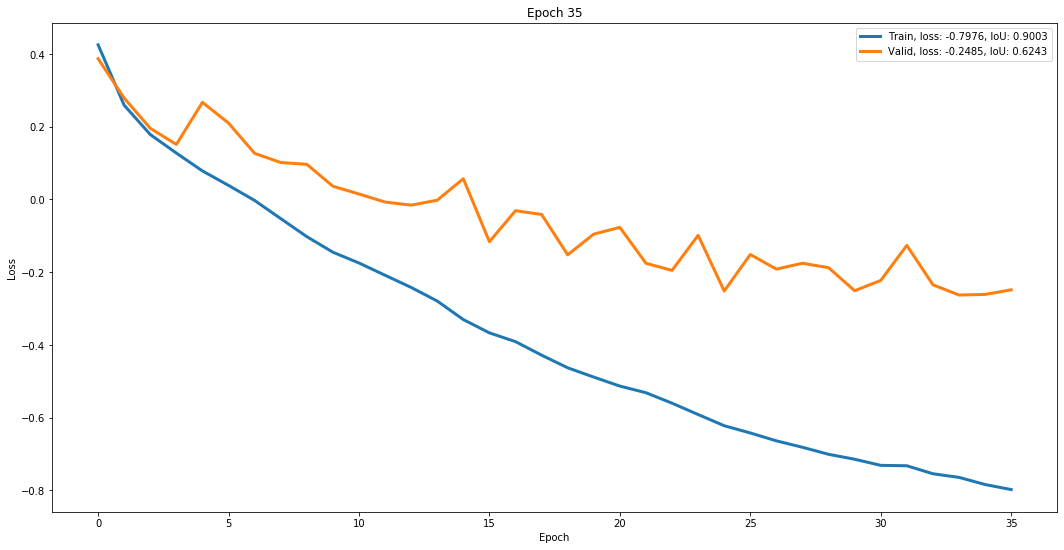

 Epoch: 36 of 100, Iter.: 44 of 44, Train Loss: -0.806755, IoU: 0.9036400
 Epoch: 36 of 100, Iter.: 44 of 44, Valid Loss: -0.270500, IoU: 0.614157


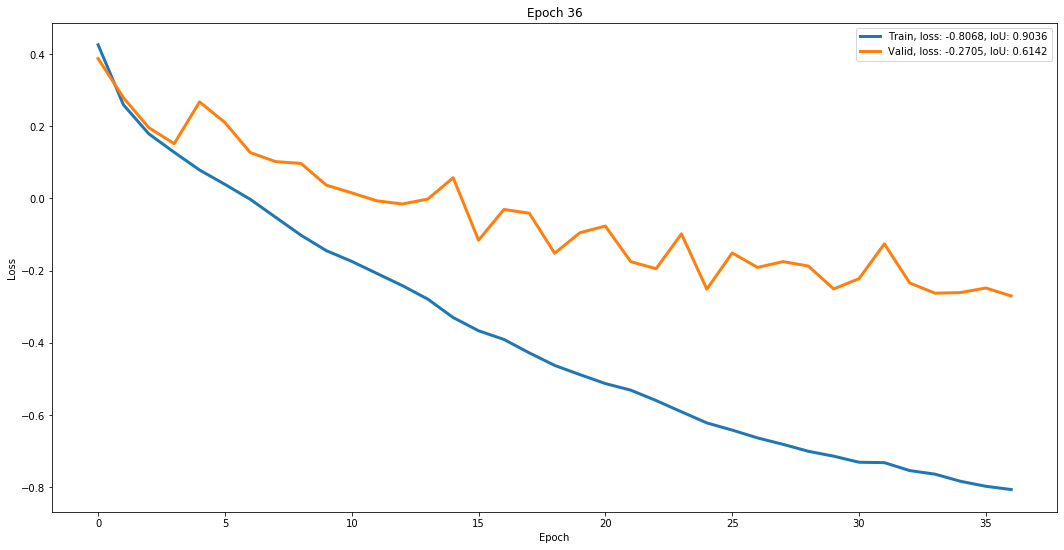

 Epoch: 37 of 100, Iter.: 44 of 44, Train Loss: -0.819399, IoU: 0.9102098
 Epoch: 37 of 100, Iter.: 44 of 44, Valid Loss: -0.229398, IoU: 0.619576


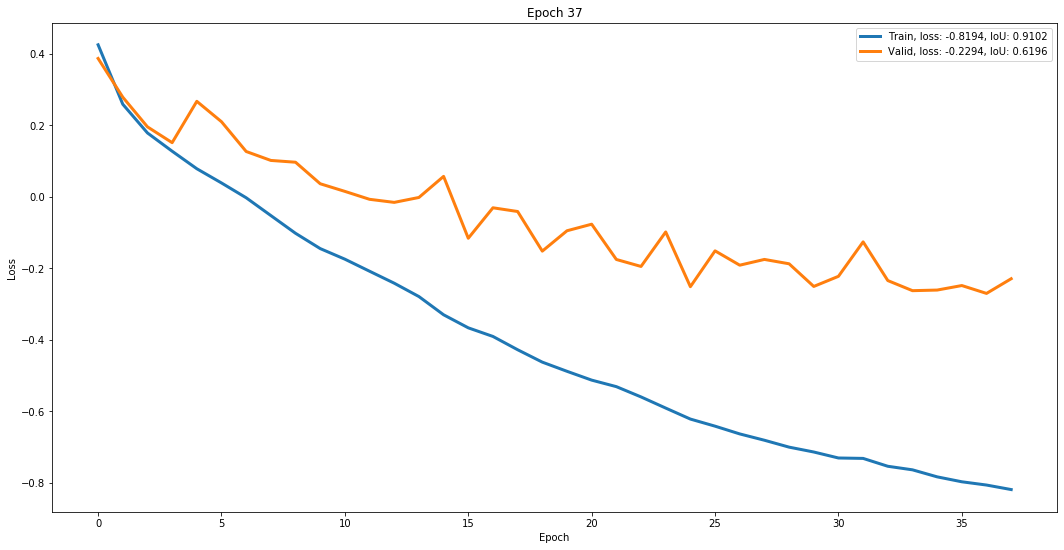

 Epoch: 38 of 100, Iter.: 44 of 44, Train Loss: -0.828315, IoU: 0.9115382
 Epoch: 38 of 100, Iter.: 44 of 44, Valid Loss: -0.232222, IoU: 0.612269


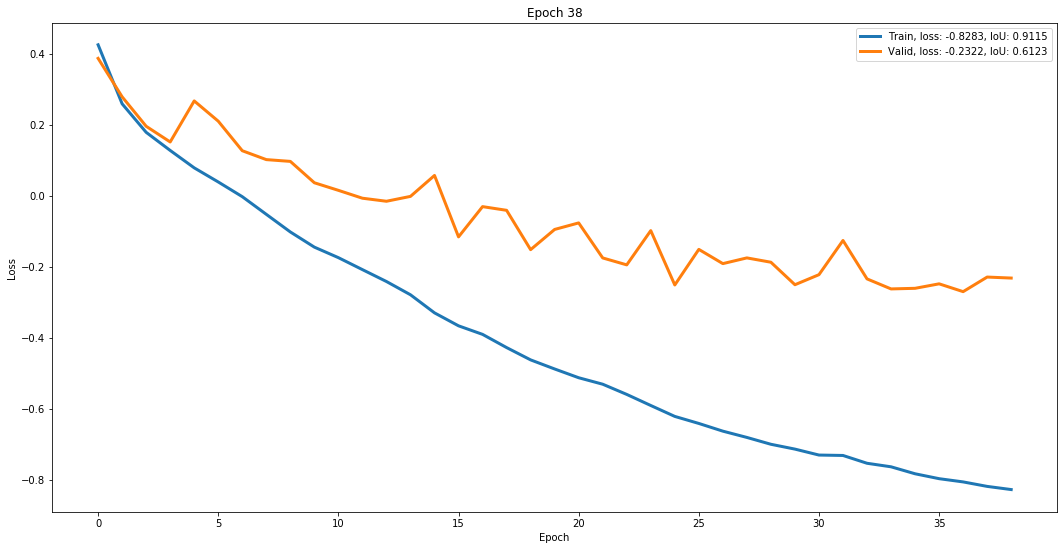

 Epoch: 39 of 100, Iter.: 44 of 44, Train Loss: -0.834757, IoU: 0.9128403
 Epoch: 39 of 100, Iter.: 44 of 44, Valid Loss: -0.265103, IoU: 0.633073


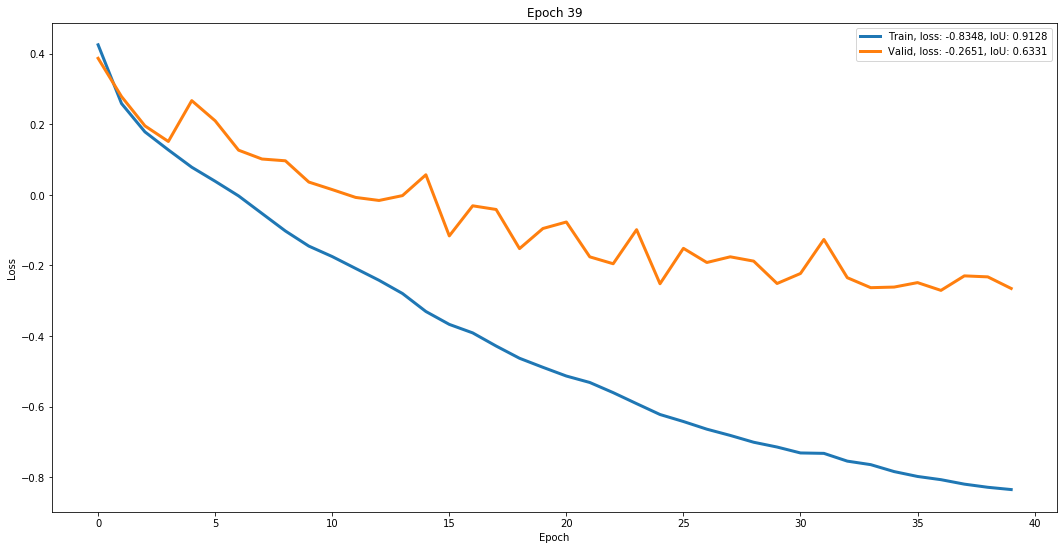

 Epoch: 40 of 100, Iter.: 44 of 44, Train Loss: -0.844980, IoU: 0.9196831
 Epoch: 40 of 100, Iter.: 44 of 44, Valid Loss: -0.270931, IoU: 0.648087


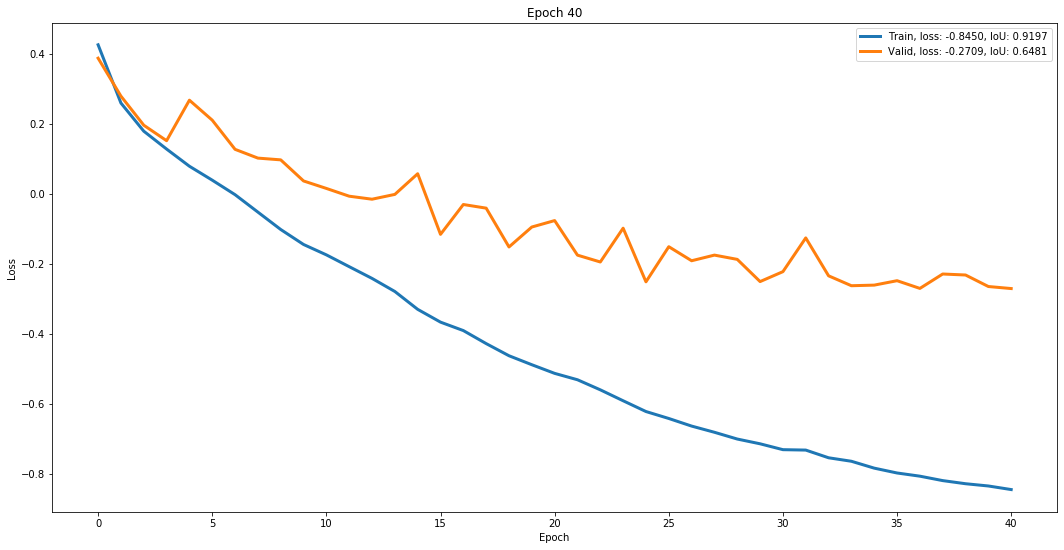

 Epoch: 41 of 100, Iter.: 44 of 44, Train Loss: -0.851796, IoU: 0.9226222
 Epoch: 41 of 100, Iter.: 44 of 44, Valid Loss: -0.229102, IoU: 0.624879


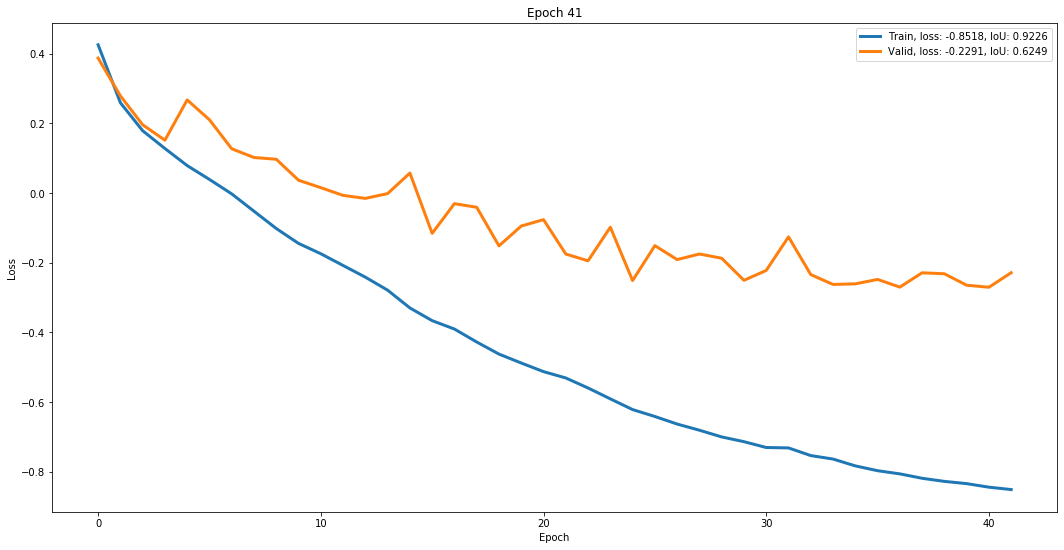

 Epoch: 42 of 100, Iter.: 44 of 44, Train Loss: -0.859703, IoU: 0.9273489
 Epoch: 42 of 100, Iter.: 44 of 44, Valid Loss: -0.277969, IoU: 0.642980


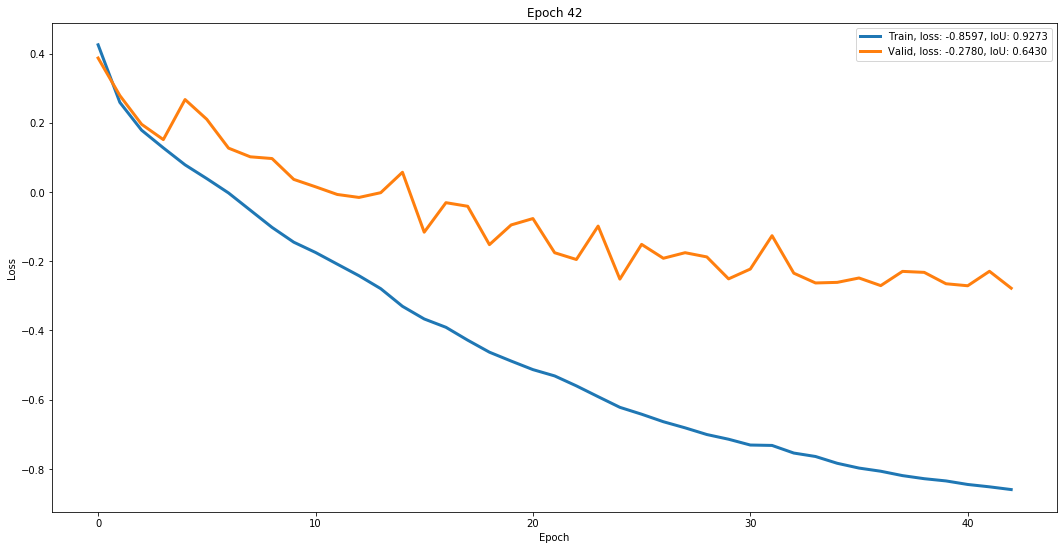

 Epoch: 43 of 100, Iter.: 44 of 44, Train Loss: -0.868058, IoU: 0.9295820
 Epoch: 43 of 100, Iter.: 44 of 44, Valid Loss: -0.263410, IoU: 0.647990


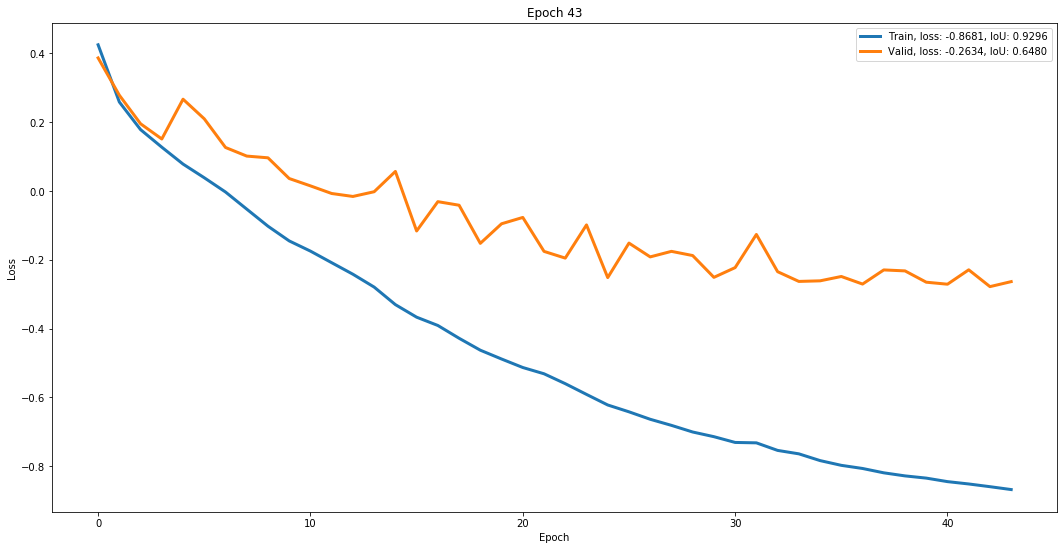

 Epoch: 44 of 100, Iter.: 44 of 44, Train Loss: -0.872322, IoU: 0.9303872
 Epoch: 44 of 100, Iter.: 44 of 44, Valid Loss: -0.225112, IoU: 0.635100


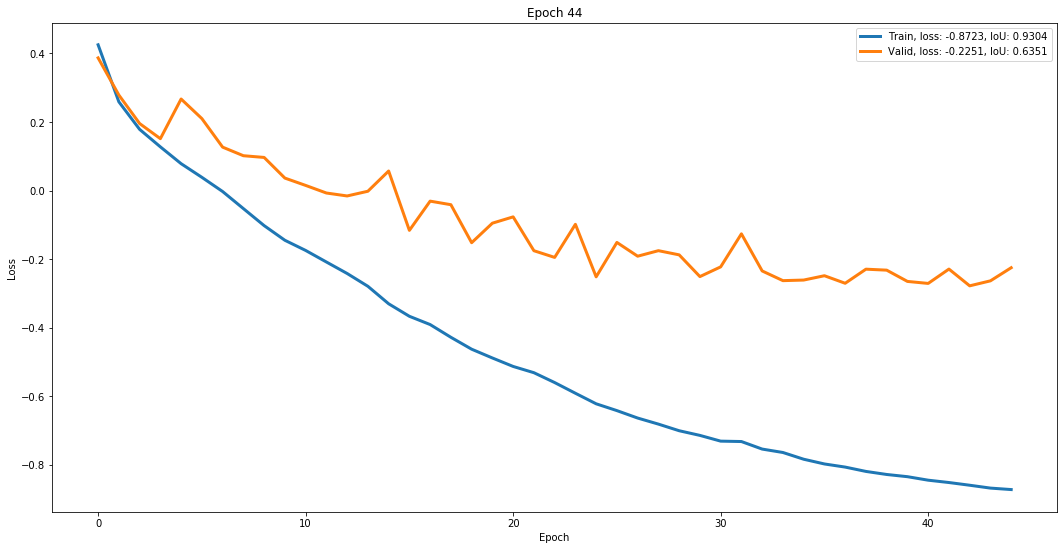

 Epoch: 45 of 100, Iter.: 44 of 44, Train Loss: -0.877600, IoU: 0.9332750
 Epoch: 45 of 100, Iter.: 44 of 44, Valid Loss: -0.279550, IoU: 0.654713


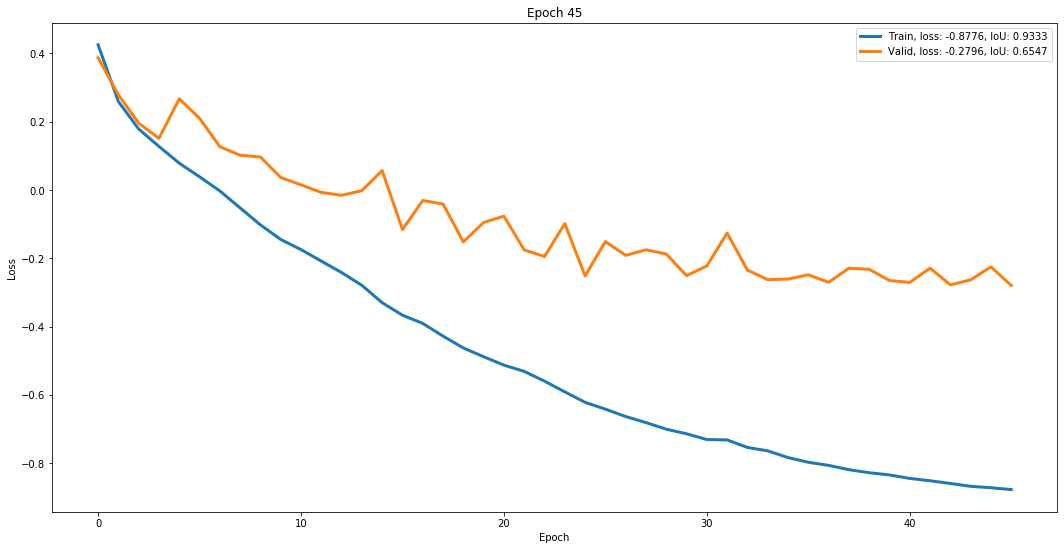

 Epoch: 46 of 100, Iter.: 44 of 44, Train Loss: -0.880266, IoU: 0.9344960
 Epoch: 46 of 100, Iter.: 44 of 44, Valid Loss: -0.265660, IoU: 0.638910


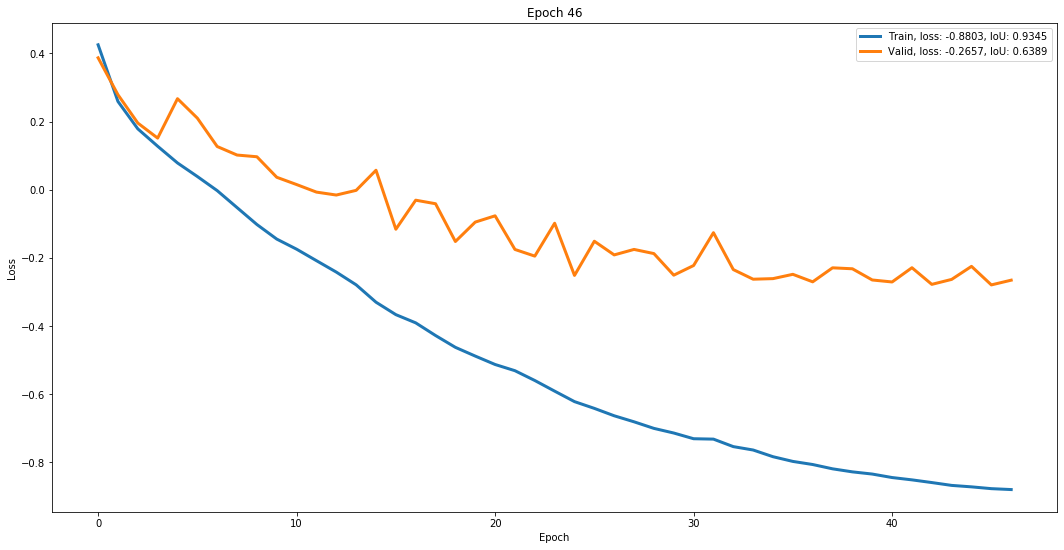

 Epoch: 47 of 100, Iter.: 44 of 44, Train Loss: -0.883628, IoU: 0.9340064
 Epoch: 47 of 100, Iter.: 44 of 44, Valid Loss: -0.275914, IoU: 0.645261


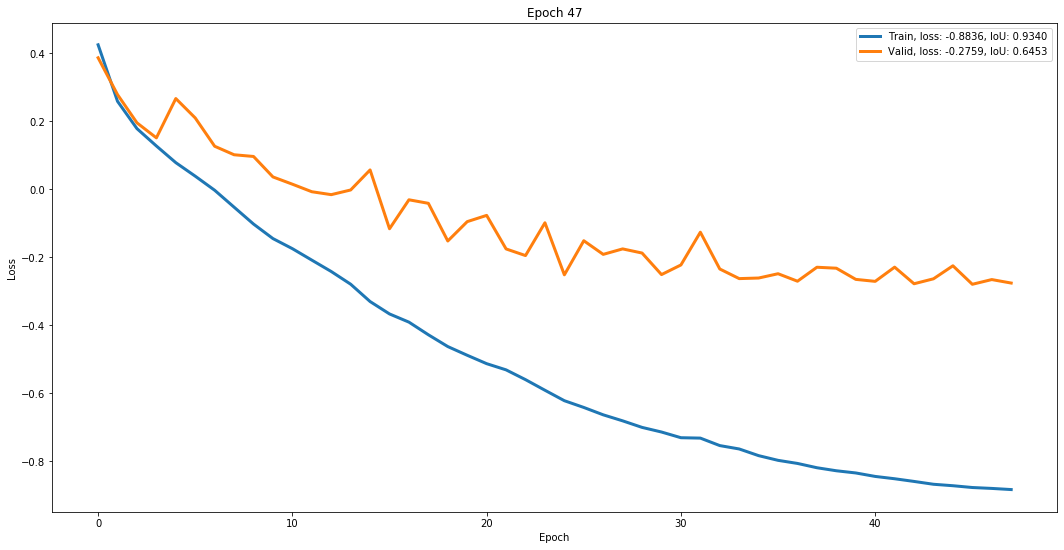

 Epoch: 48 of 100, Iter.: 44 of 44, Train Loss: -0.885570, IoU: 0.9317014
 Epoch: 48 of 100, Iter.: 44 of 44, Valid Loss: -0.216584, IoU: 0.619686


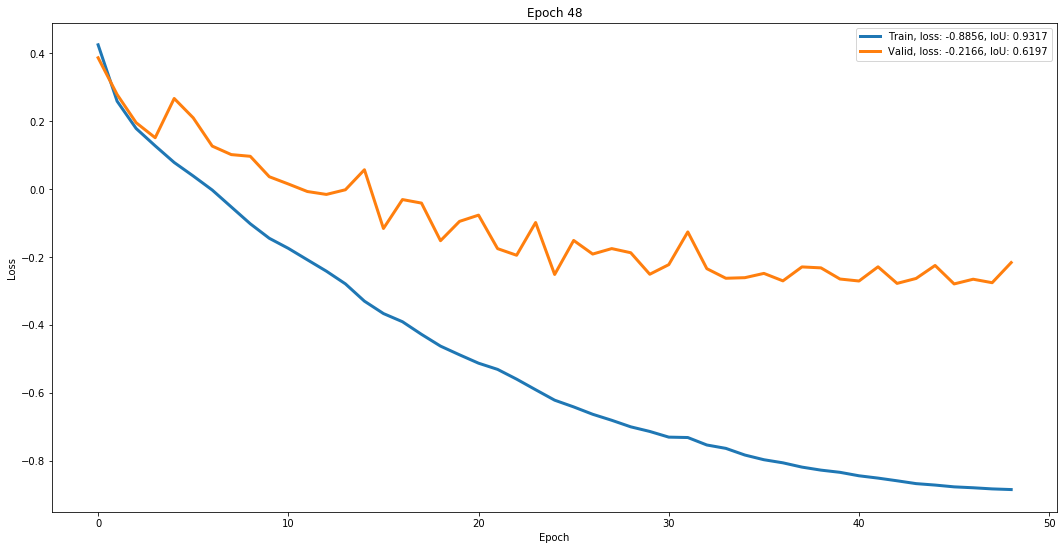

 Epoch: 49 of 100, Iter.: 44 of 44, Train Loss: -0.887743, IoU: 0.9318655
 Epoch: 49 of 100, Iter.: 44 of 44, Valid Loss: -0.267665, IoU: 0.645791


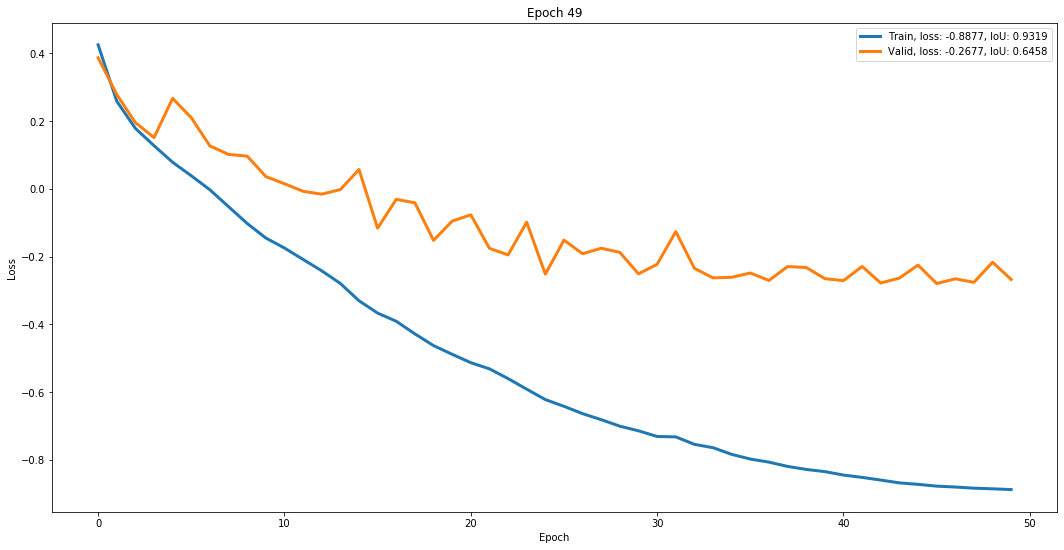

 Epoch: 50 of 100, Iter.: 44 of 44, Train Loss: -0.890130, IoU: 0.9333375
 Epoch: 50 of 100, Iter.: 44 of 44, Valid Loss: -0.255385, IoU: 0.623386


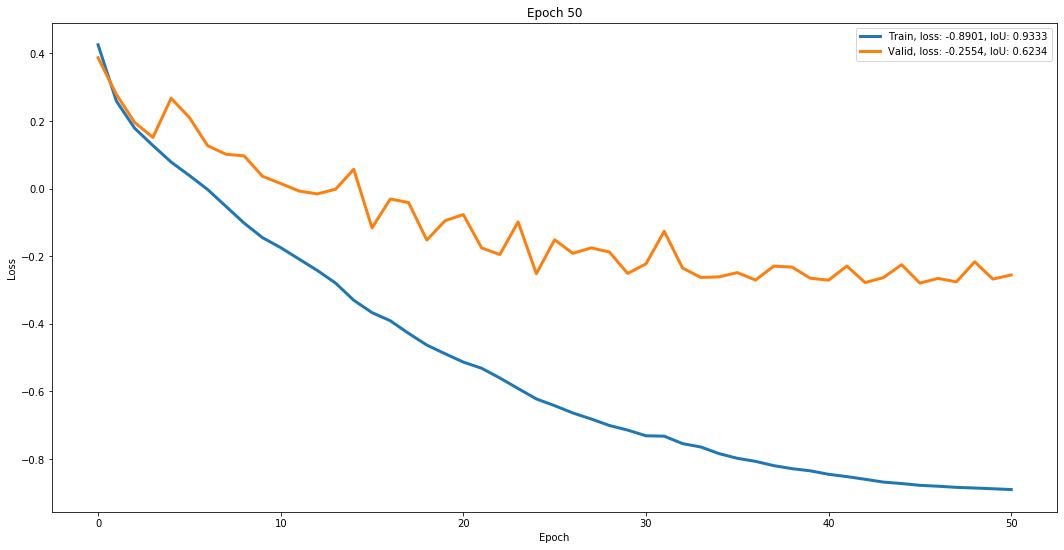

 Epoch: 51 of 100, Iter.: 44 of 44, Train Loss: -0.892864, IoU: 0.9347572
 Epoch: 51 of 100, Iter.: 44 of 44, Valid Loss: -0.249372, IoU: 0.645413


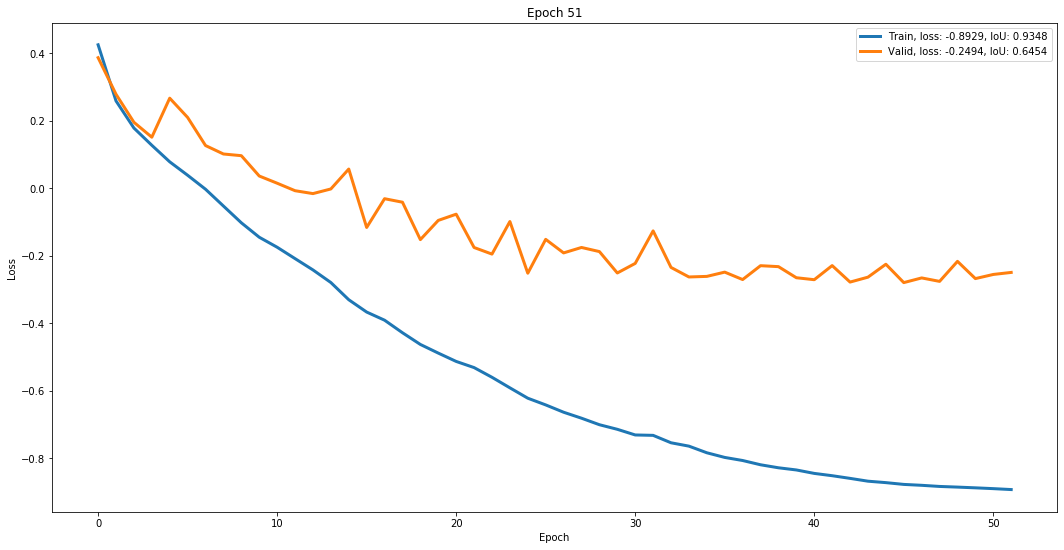

 Epoch: 52 of 100, Iter.: 44 of 44, Train Loss: -0.889896, IoU: 0.9296409
 Epoch: 52 of 100, Iter.: 44 of 44, Valid Loss: -0.200329, IoU: 0.621425


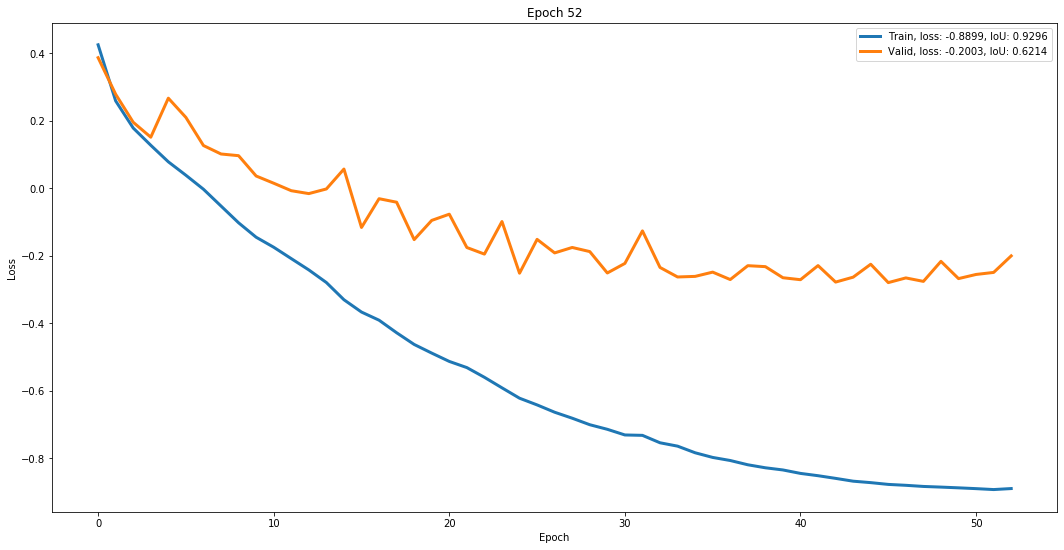

 Epoch: 53 of 100, Iter.: 44 of 44, Train Loss: -0.795463, IoU: 0.8703340
 Epoch: 53 of 100, Iter.: 44 of 44, Valid Loss: -0.229720, IoU: 0.623738


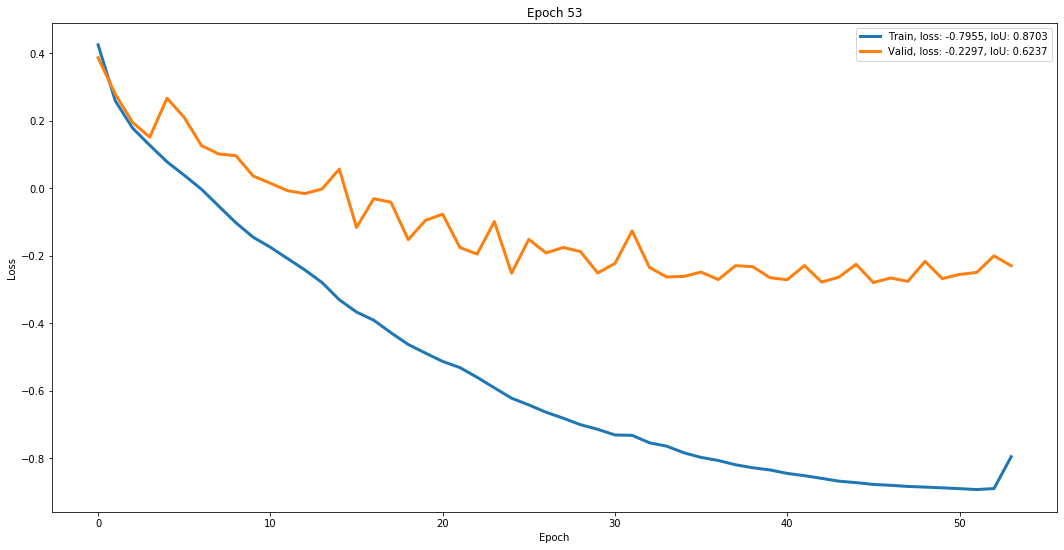

 Epoch: 54 of 100, Iter.: 44 of 44, Train Loss: -0.799324, IoU: 0.8672310
 Epoch: 54 of 100, Iter.: 44 of 44, Valid Loss: -0.116130, IoU: 0.574715


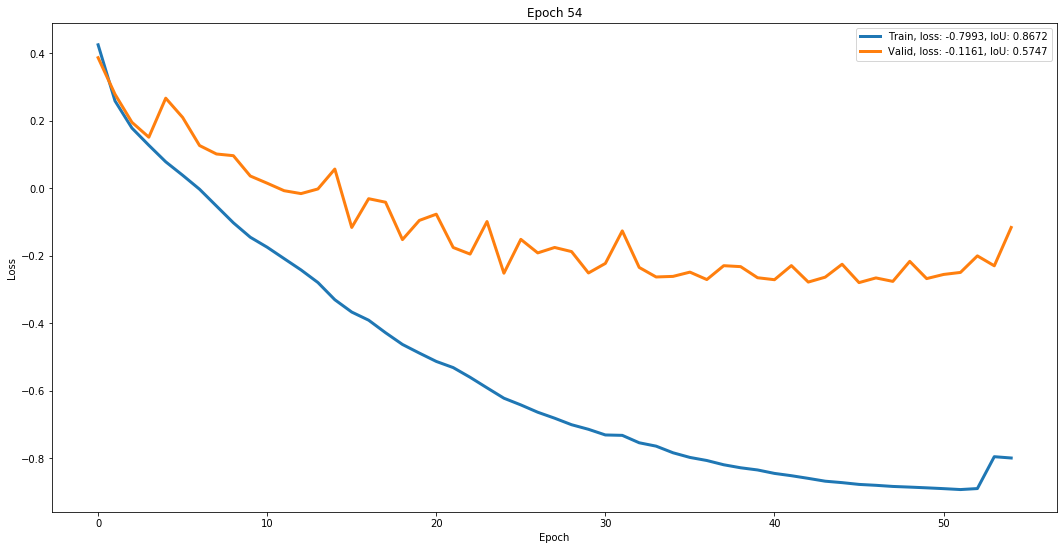

 Epoch: 55 of 100, Iter.: 44 of 44, Train Loss: -0.824018, IoU: 0.8838580
 Epoch: 55 of 100, Iter.: 44 of 44, Valid Loss: -0.264370, IoU: 0.642439


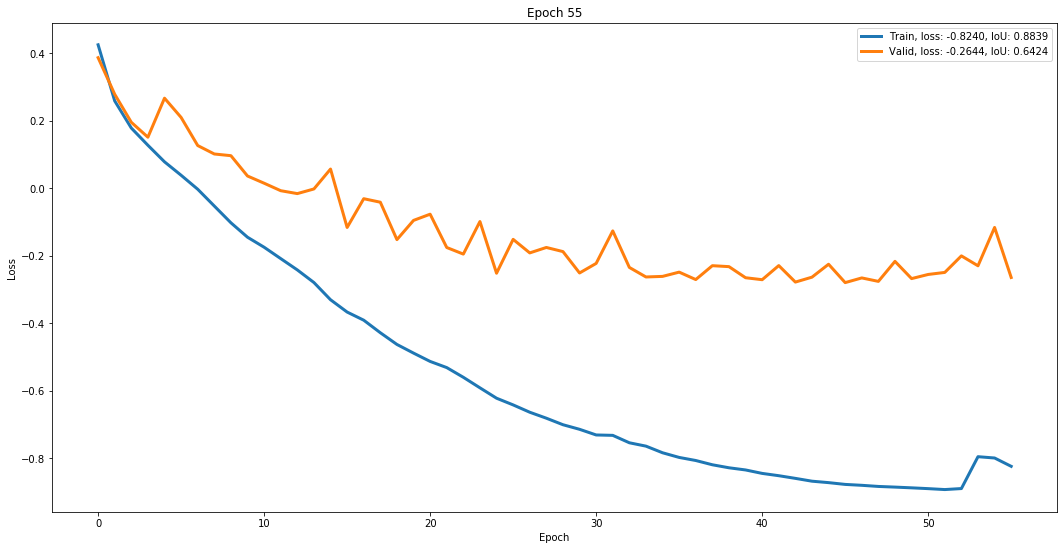

 Epoch: 56 of 100, Iter.: 44 of 44, Train Loss: -0.869566, IoU: 0.9142826
 Epoch: 56 of 100, Iter.: 44 of 44, Valid Loss: -0.189226, IoU: 0.616885


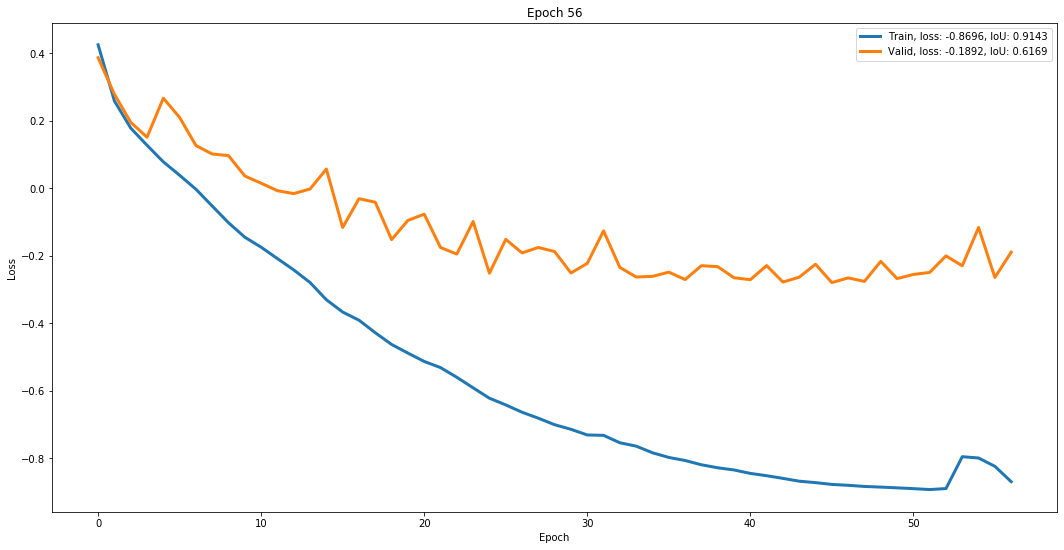


Early stopping. Target criteria has not improved for 10 epochs.

CPU times: user 13min 56s, sys: 10min 32s, total: 24min 29s
Wall time: 25min 18s


In [126]:
%%time

train_losses = []
val_losses = []
best_iou = 0
best_loss = np.Inf
best_epoch = -1
state = {}


for epoch in range(epochs):
    running_loss = 0
    running_iou = 0
    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimiser.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimiser.step()
        
        running_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1)), end="")
        
        running_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_iou/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss = 0
    val_iou = 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)
    # compute overall epoch iou-s
    epoch_train_iou = running_iou/len(dataloader_train)
    epoch_val_iou = val_iou/len(dataloader_val)
    
    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou))
    
    
    # plot
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {epoch_train_loss:.4f}, IoU: {epoch_train_iou:.4f}', linewidth=3)
    plt.plot(np.arange(len(val_losses)), val_losses, label=f'Valid, loss: {epoch_val_loss:.4f}, IoU: {epoch_val_iou:.4f}', linewidth=3)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Epoch {epoch}')
    plt.legend(loc='best')
    plt.show()
    
    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch = epoch if best_iou == epoch_val_iou else best_epoch
    
    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['iou'] = best_iou
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, f'../checkpoints/ckpt_{model_name}.pth')
    
    elif best_epoch + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break
        
        
# load once more and write all the losses down (othw can miss the last 10)
state = torch.load(f'../checkpoints/ckpt_{model_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'../checkpoints/ckpt_{model_name}.pth')

In [127]:
best_epoch, best_iou

(45, tensor(0.6547, device='cuda:0'))

## Evaluate validation performance (256*256 images)

In [128]:
%ls ../checkpoints

ckpt_UNet_BCELoss_baseline.pth     ckpt_UNet_IoULoss_baseline.pth
ckpt_UNet_IoUBCELoss_baseline.pth  ckpt_UNet_IoULoss_baseline_submitted.pth
ckpt_UNet_IoULoss_attention.pth    README.md
ckpt_UNet_IoULoss_augmented.pth


In [129]:
# Begin training
model = UNet(channel_in=3, channel_out=1)
model = model.to(DEVICE) # load model to DEVICE

# load best weights and put into the evaluation mode
print(model_name)
model.load_state_dict(torch.load(f'../checkpoints/ckpt_{model_name}.pth')['net'])

UNet_IoUBCELoss_baseline


<All keys matched successfully>

In [130]:
print('Best epoch:', torch.load(f'../checkpoints/ckpt_{model_name}.pth')['epoch'])
print(f'Validation IoU ({_size[0]}x{_size[0]}):', torch.load(f'../checkpoints/ckpt_{model_name}.pth')['iou'].item())

Best epoch: 45
Validation IoU (256x256): 0.6547133326530457


## TODO: Pipeline

In [69]:
# def train(model, optim, criterion, dataloader, epoch, device):
#     pass

In [70]:
# def test(model, criterion, dataloader, epoch, device, best_acc, model_name='model'):
#     pass

In [71]:
# # Begin training
# model = UNet(channel_in=3, channel_out=1)
# model = model.to(DEVICE)

# train_losses = []
# test_losses = []
# best_iou = 0
# best_epoch = -1

# for epoch in notebook.tqdm(range(30)):
#     train_loss, train_iou = train(model, optimiser, criterion, dataloader_train, epoch, DEVICE)
#     train_losses.append(train_loss)
    
#     test_loss, test_iou = test(model, criterion, dataloader_val, epoch, DEVICE, best_iou, model_name='Unet_BCEWithLogitsLoss')
#     #scheduler.step(test_loss) # not always needed
#     test_losses.append(test_loss)
    
#     best_iou = max(best_iou, test_iou)
#     best_epoch = epoch if best_iou == test_iou else best_epoch

#     clear_output()
    
#     plt.figure(figsize=(18, 9))
#     plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, IoU: {train_iou}%')
#     plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, IoU: {test_iou}%')
#     plt.title(f'Epoch {epoch}')
#     plt.legend(loc='best')
#     plt.show()